# Conduit Experiment Analysis

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sp

### Plot of theoretical speed-amplitude relation

In [2]:
avals = np.linspace(1.1, 30, 100)
cvals = (avals**2 * np.log(avals**2) - avals**2 + 1) / ((avals-1)**2)

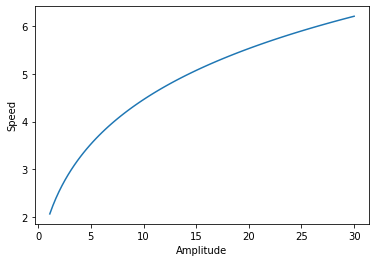

In [3]:
plt.plot(avals,cvals)
plt.ylabel('Speed')
plt.xlabel('Amplitude')
plt.show()

### Conduit

In [15]:
# Data dictionary
dict07 = sp.loadmat('expData07.mat')
# dict07

In [5]:
A0 = 8.46

In [6]:
A0_error = .2

In [7]:
# Amplitude Matrix
mat07 = dict07['Amat']
mat07.shape

(227, 4418)

In [14]:
dict07['U0'][0,0]

0.12938929125181425

In [9]:
dict07['z_vec'].size

4418

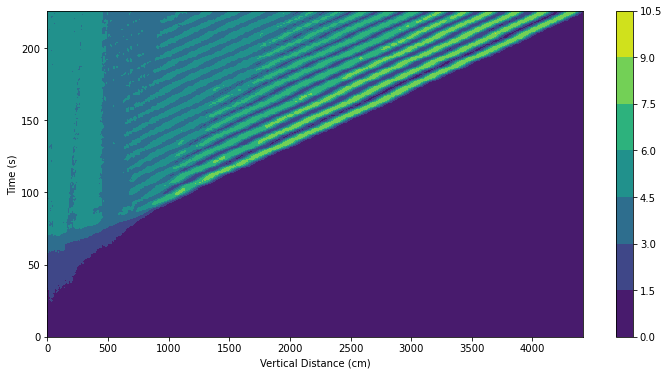

In [232]:
plt.figure(figsize = (12,6))
plt.contourf(mat07)
plt.colorbar()
plt.xlabel('Vertical Distance (cm)')
plt.ylabel('Time (s)')
# plt.plot([1000,4000],[110, 220])
plt.show()

In [11]:
# or for each vertical distance coordinate where there is a possible soliton index, take the smallest index from that
## list, generate a list of all the points of the soliton to find a more accurate slope

### Building the function

In [28]:
fullWaveIdxs = []                  # first get possible soliton indexes
for i in range(227):
    for j in range(4418):
        if (mat07[i,j]>8.26) & (mat07[i,j]<8.66):
            fullWaveIdxs.append((i,j))

In [29]:
solitonIdxs = []
dists = [idx[1] for idx in fullWaveIdxs]
for d in set(dists):
    column_idxs = [idx for idx in fullWaveIdxs if idx[1] == d]
    solitonIdxs.append(min(column_idxs))

In [30]:
dists = [idx[1] for idx in fullWaveIdxs]
# set(dists)

In [31]:
# solitonIdxs[40:50]

In [32]:
solitonIdxs = [(idx[1],idx[0]) for idx in solitonIdxs]
# solitonIdxs[40:50]

In [33]:
xvals = [idx[0] for idx in solitonIdxs]
yvals = [idx[1] for idx in solitonIdxs]

In [39]:
# solitonIdxs[40:50]

In [38]:
# list(zip(*solitonIdxs[40:50]))

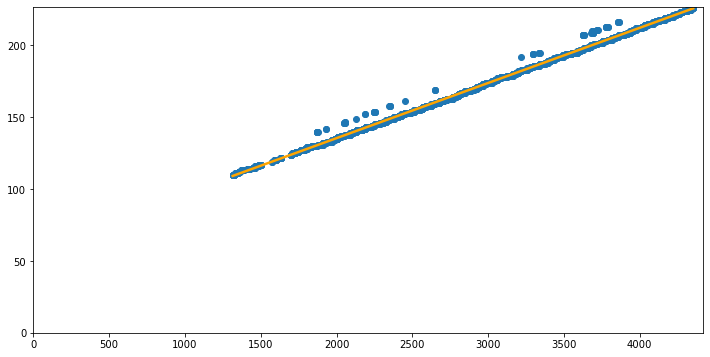

In [36]:
m, b = np.polyfit(xvals, yvals, deg = 1)
y_hat_vals = [m*x + b for x in xvals]

plt.figure(figsize = (12,6))
plt.scatter(*zip(*solitonIdxs))
plt.plot(xvals, y_hat_vals, c = 'orange', linewidth = 2.5)
plt.xlim(0,4417)
plt.ylim(0,227)
plt.show()

In [37]:
1/m

26.04626658704094

In [3]:
def compute_soliton_speed(dictionary):
    mat = dictionary['Amat']
    times = mat.shape[0]
    distances = mat.shape[1]
    a0 = dictionary['A0'][0,0]
    a0_error = dictionary['A0_error'][0,0]
    solitonAmpRange = ((a0 - a0_error), (a0 + a0_error))
    
    # first get possible soliton indexes
    fullWaveIdxs = []                    
    for i in range(times):
        for j in range(distances):
            if (mat[i,j]>solitonAmpRange[0]) & (mat[i,j]<solitonAmpRange[1]):
                fullWaveIdxs.append((i,j))
                
    # next, get the index with the smallest time coordinate from every column where there is a soliton
    solitonIdxs = []           
    columns = [idx[1] for idx in fullWaveIdxs]                  
    for d in set(columns):
        column_idxs = [idx for idx in fullWaveIdxs if idx[1] == d]
        solitonIdxs.append(min(column_idxs))
        
    # change order of the coordinates for each soliton index to switch from matrix indexing to cartesian coordinates
    solitonIdxs = [(idx[1],idx[0]) for idx in solitonIdxs]

    # separate the time values and the distance values for use of polyfit() function
    xvals = [idx[0] for idx in solitonIdxs]
    yvals = [idx[1] for idx in solitonIdxs]
    m, b = np.polyfit(xvals, yvals, deg = 1)
    
    # calculating real_speed by adjusting scales of the matrix indices
    index_speed = 1/m # zidx / tidx
    cm_per_zidx = dictionary['z_vec'][-1][-1] / dictionary['z_vec'].size
    real_distance = index_speed * cm_per_zidx
    sec_per_tidx = dictionary['t_vec'][-1][-1] / dictionary['t_vec'].size
    
    
    if dictionary['t_vec'][dictionary['t_vec'] < 0].size > 0:  # in case the time vector has negative time values
        average = 1.2371625245444737
        sec_per_tidx = average
    
    real_speed = real_distance / sec_per_tidx  # cm / sec
    
    # return all useful information for tracking speed and for plotting 
    return {'real_speed':real_speed, 'index_speed':index_speed,
            'solitonIdxs':solitonIdxs, 'xvals':xvals, 'yvals':yvals, 'b':b}

In [18]:
# compute_soliton_speed(sp.loadmat('expData07.mat'))

In [94]:
idxs = [idx for idx in fullWaveIdxs if idx[1] == 2217]
idxs

[(143, 2217), (144, 2217), (153, 2217)]

In [95]:
min(idxs)

(143, 2217)

In [43]:
for num in range(7,10):
    data = 'expData0' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    if dictionary['t_vec'][dictionary['t_vec'] < 0].size > 0:
        print('True', num)

for num in range(10,14):
    data = 'expData' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    if dictionary['t_vec'][dictionary['t_vec'] < 0].size > 0:
        print('True', num)
    
for num in range(17,49):
    data = 'expData' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    if dictionary['t_vec'][dictionary['t_vec'] < 0].size > 0:
        print('True', num)

True 7
True 35


Two of our 39 datasets have negative numbers in the time vectors. I believe that this is just some odd experimental measurement error. All the other datasets have similar, monotonic time vectors. 
Because of this, I will find the average time adjustment from all the other datasets and apply this average to the 2 datasets with botched time vectors. 

In [53]:
# sec_per_tidx = dictionary['t_vec'][-1][-1] / dictionary['t_vec'].size
sec_per_tidx_list = []
for num in range(7,10):
    data = 'expData0' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    if dictionary['t_vec'][dictionary['t_vec'] < 0].size == 0:
        sec_per_tidx_list.append(dictionary['t_vec'][-1][-1] / dictionary['t_vec'].size)

for num in range(10,14):
    data = 'expData' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    if dictionary['t_vec'][dictionary['t_vec'] < 0].size == 0:
        sec_per_tidx_list.append(dictionary['t_vec'][-1][-1] / dictionary['t_vec'].size)
    
for num in range(17,49):
    data = 'expData' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    if dictionary['t_vec'][dictionary['t_vec'] < 0].size == 0:
        sec_per_tidx_list.append(dictionary['t_vec'][-1][-1] / dictionary['t_vec'].size)

average = sum(sec_per_tidx_list) / len(sec_per_tidx_list)
average

1.2371625245444737

### Examining specific solitons

In [4]:
dict35 = sp.loadmat('expData35.mat')
dict35

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Mon Nov 13 15:02:50 2017',
 '__version__': '1.0',
 '__globals__': [],
 'A0': array([[6.98]]),
 'A0_error': array([[0.3]]),
 'Amat': array([[1.30524241, 1.3212575 , 1.3682535 , ..., 1.02941121, 1.0622817 ,
         1.055092  ],
        [1.52968565, 1.53834015, 1.51416908, ..., 1.        , 1.        ,
         1.055092  ],
        [1.37807935, 1.64409837, 1.61377662, ..., 1.0723883 , 1.06949582,
         1.07673435],
        ...,
        [3.52001279, 3.5594524 , 3.57528976, ..., 5.99492641, 5.98124717,
         6.22288956],
        [3.5594524 , 3.5594524 , 3.5515469 , ..., 4.57191886, 4.67710336,
         4.79877902],
        [3.5594524 , 3.65233262, 3.62301279, ..., 1.71106832, 1.83763444,
         2.06195562]]),
 'U0': array([[0.23623145]]),
 't_vec': array([[ 0.00000e+00,  7.90000e-01,  1.79000e+00,  2.79000e+00,
          3.79000e+00,  4.79000e+00,  5.79000e+00,  6.79000e+00,
          7.80000e+00,  8.79000e+00,  9.7

In [10]:
dict35['t_vec'].max() - dict35['t_vec'].min()   # the experiment did not last 3600 seconds, 1 hour

3599.0

In [48]:
dict07 = sp.loadmat('expData07.mat')
# dict07

In [50]:
dict07['t_vec'][dict07['t_vec'] < 0].size

178

In [34]:
dict07 = sp.loadmat('expData07.mat')
dict07['t_vec'].min()

-3543.33

In [35]:
dict07['t_vec'].max()

55.67000000000007

In [28]:
mat07 = dict07['Amat']
mat07.shape

(227, 4418)

In [29]:
dict07['t_vec'].size

227

In [30]:
dict07['t_vec'][-1][-1]

-3309.34

In [10]:
dict07['z_vec'].size

5056

In [11]:
dict07['z_vec'][-1][-1]

104.89125

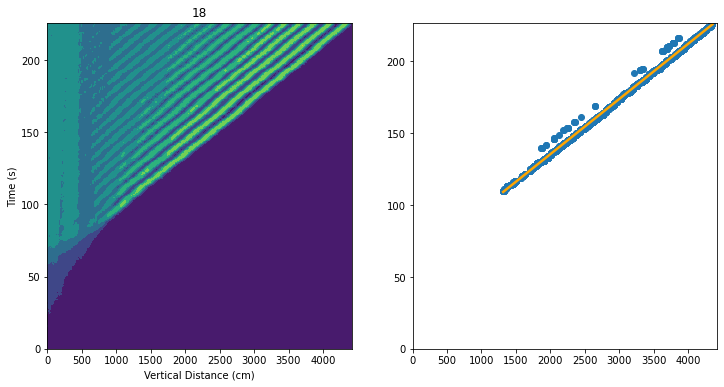

In [38]:
dictionary = dict07
a0 = dictionary['A0'][0,0]

new_dict = compute_soliton_speed(dictionary)
m = (1 / new_dict['index_speed'])



y_hat_vals = [m*x + new_dict['b'] for x in new_dict['xvals']]

plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.contourf(dictionary['Amat'])
plt.xlabel('Vertical Distance (cm)')
plt.ylabel('Time (s)')
plt.title('18')

plt.subplot(1, 2, 2)
plt.scatter(*zip(*new_dict['solitonIdxs']))
plt.plot(new_dict['xvals'], y_hat_vals, c = 'orange', linewidth = 2.5)
plt.xlim(0,dictionary['z_vec'].size)
plt.ylim(0,dictionary['t_vec'].size)
plt.show()

In [13]:
# new_dict['xvals']

In [14]:
new_dict['speed']

25.533728945610157

In [15]:
cm_per_zidx = dict07['z_vec'][-1][-1] / dict07['z_vec'].size
cm_per_zidx

0.020745895965189873

In [19]:
real_distance = new_dict['speed'] * cm_per_zidx
real_distance

0.5297200843089857

In [17]:
sec_per_tidx = dict07['t_vec'][-1][-1] / dict07['t_vec'].size
sec_per_tidx

1.2457216494845358

In [20]:
real_speed = real_distance / sec_per_tidx
real_speed

0.4252314989694345

# Finding speeds of all the solitons

In [12]:
speeds_list = []
a0_list = []
u0_list = []

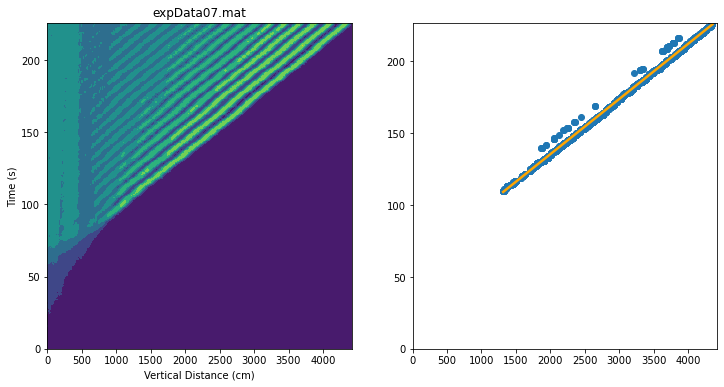

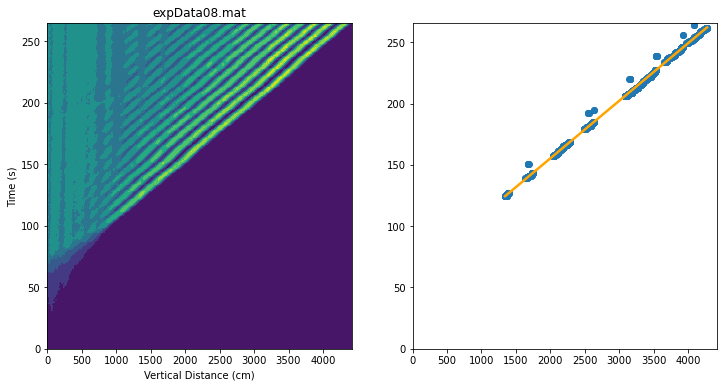

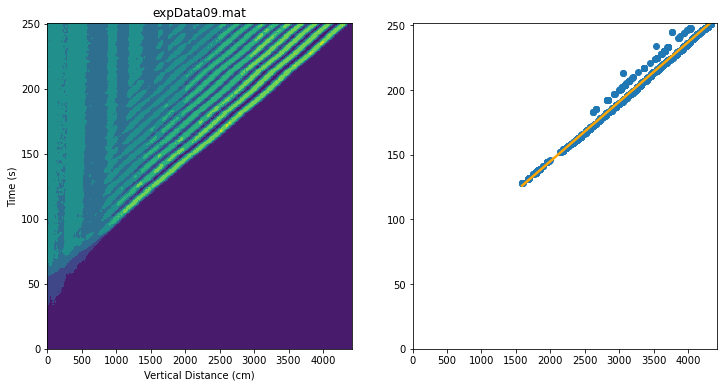

In [13]:
# data sets [7-9]
for num in range(7,10):
    data = 'expData0' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    a0 = dictionary['A0'][0,0]
    a0_list.append(a0)
    u0_list.append(dictionary['U0'][0,0])
    
    new_dict = compute_soliton_speed(dictionary)
    
    # append speed to list
    speeds_list.append( (a0, new_dict['real_speed'], num) )
    
    #make two plots side by side
    m = (1 / new_dict['index_speed'])
    y_hat_vals = [m*x + new_dict['b'] for x in new_dict['xvals']]
    
    plt.figure(figsize = (12, 6))
    
    plt.subplot(1, 2, 1)
    plt.contourf(dictionary['Amat'])
    plt.xlabel('Vertical Distance (cm)')
    plt.ylabel('Time (s)')
    plt.title(data)
    
    plt.subplot(1, 2, 2)
    plt.scatter(*zip(*new_dict['solitonIdxs']))
    plt.plot(new_dict['xvals'], y_hat_vals, c = 'orange', linewidth = 2.5)
    plt.xlim(0,dictionary['z_vec'].size)
    plt.ylim(0,dictionary['t_vec'].size)
    
    plt.show()    

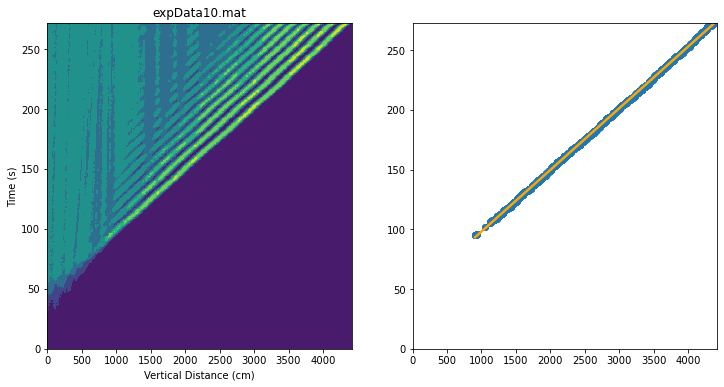

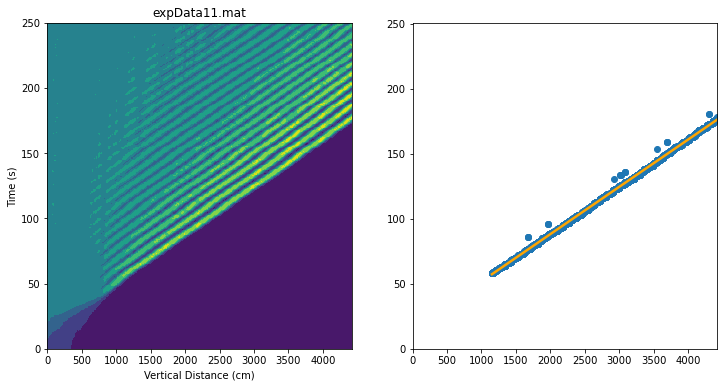

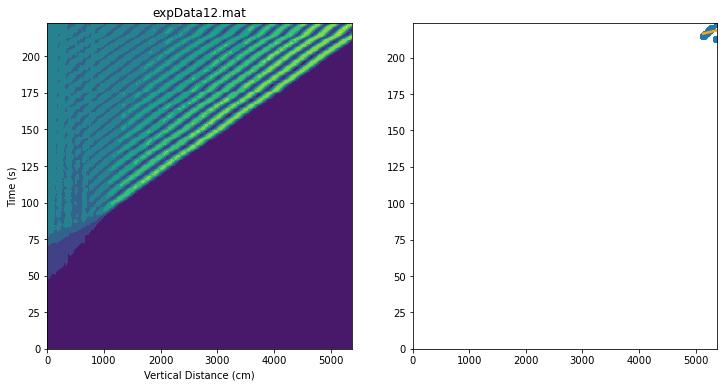

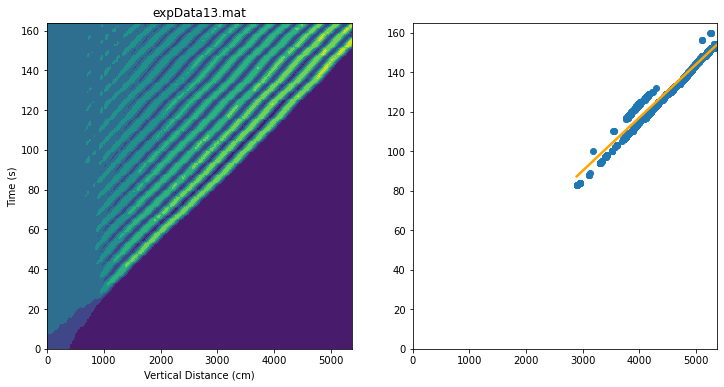

In [14]:
# data sets [10-13]
for num in range(10,14):
    data = 'expData' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    a0 = dictionary['A0'][0,0]
    a0_list.append(a0)
    u0_list.append(dictionary['U0'][0,0])
    
    new_dict = compute_soliton_speed(dictionary)
    
    # append speed to list
    speeds_list.append( (a0, new_dict['real_speed'], num) )
    
    #make two plots side by side
    m = (1 / new_dict['index_speed'])
    y_hat_vals = [m*x + new_dict['b'] for x in new_dict['xvals']]
    
    plt.figure(figsize = (12, 6))
    
    plt.subplot(1, 2, 1)
    plt.contourf(dictionary['Amat'])
    plt.xlabel('Vertical Distance (cm)')
    plt.ylabel('Time (s)')
    plt.title(data)
    
    plt.subplot(1, 2, 2)
    plt.scatter(*zip(*new_dict['solitonIdxs']))
    plt.plot(new_dict['xvals'], y_hat_vals, c = 'orange', linewidth = 2.5)
    plt.xlim(0,dictionary['z_vec'].size)
    plt.ylim(0,dictionary['t_vec'].size)
    
    plt.show()

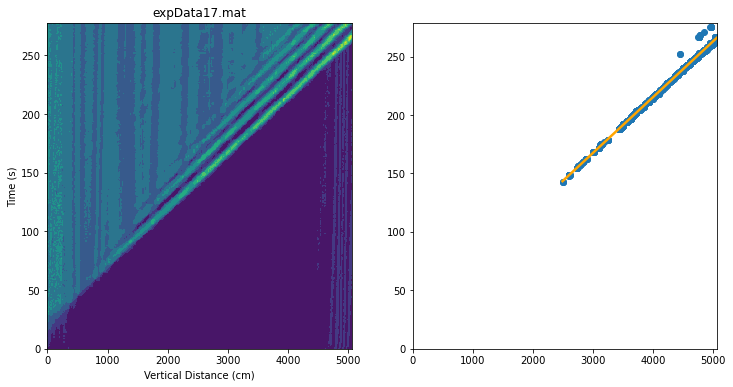

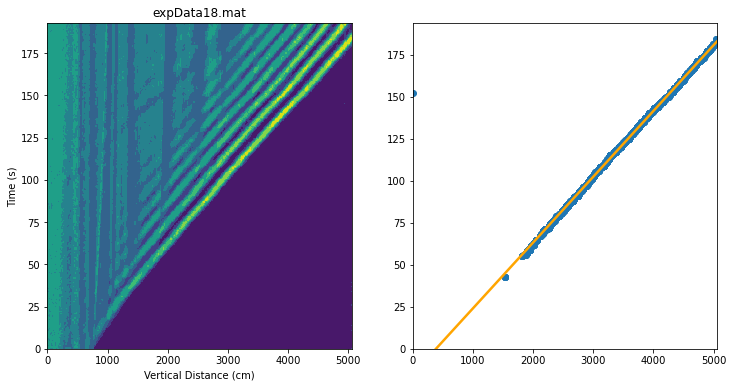

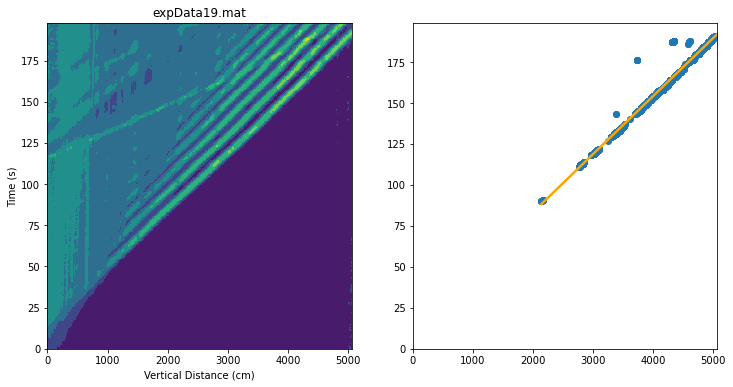

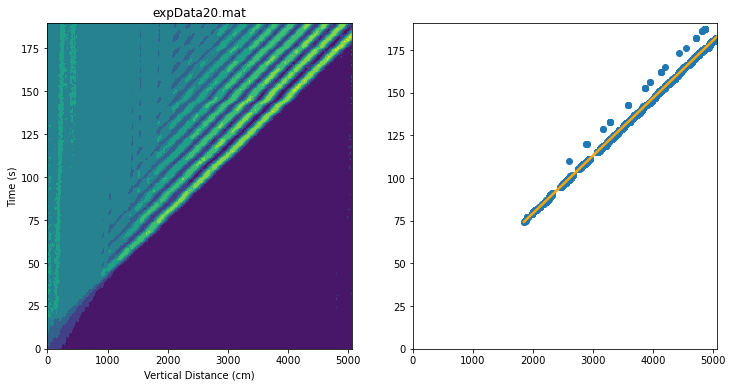

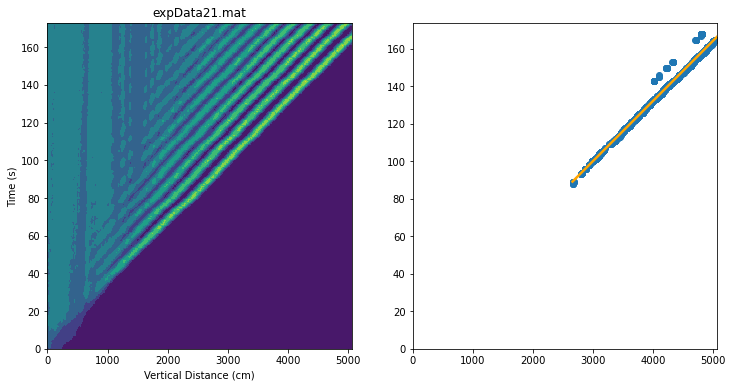

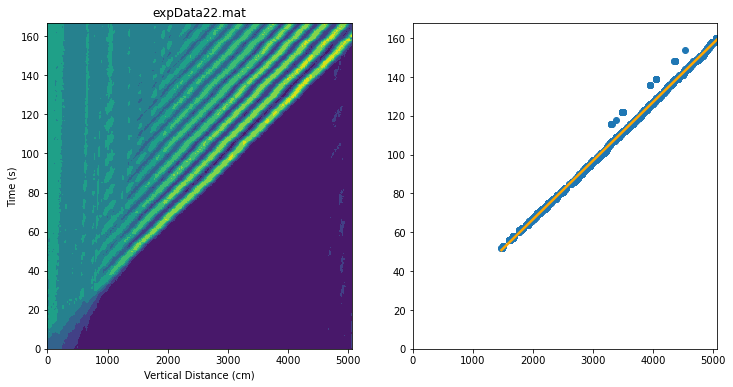

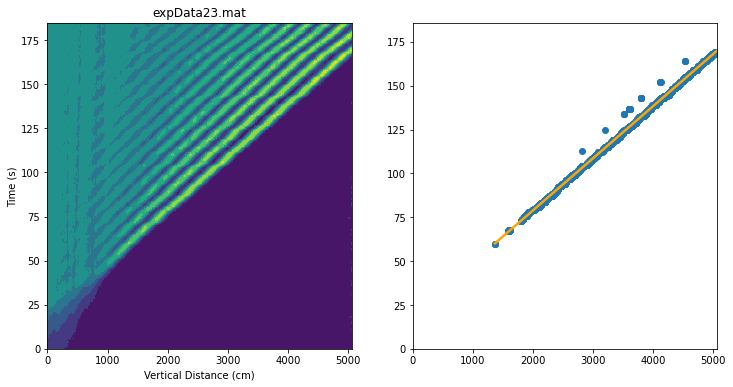

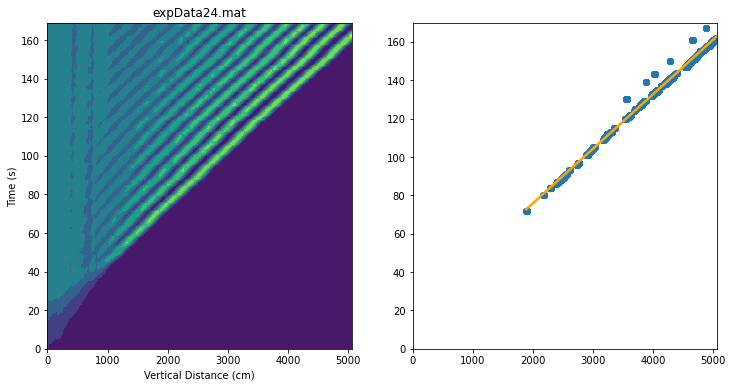

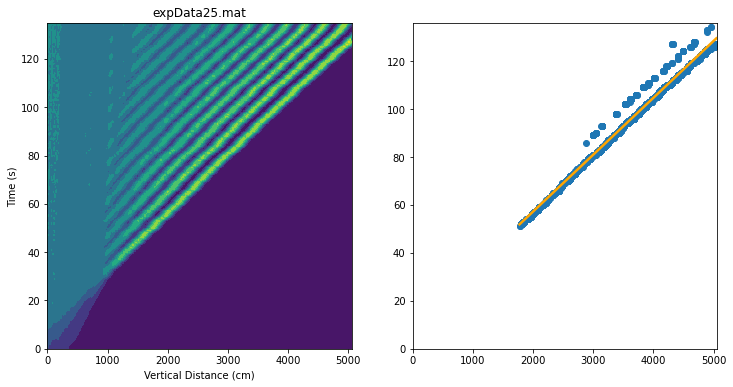

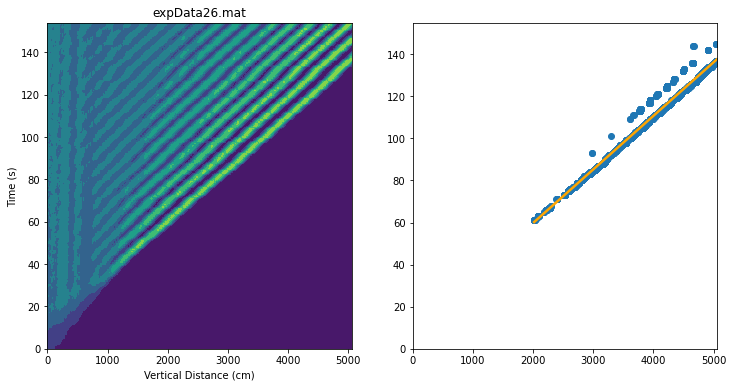

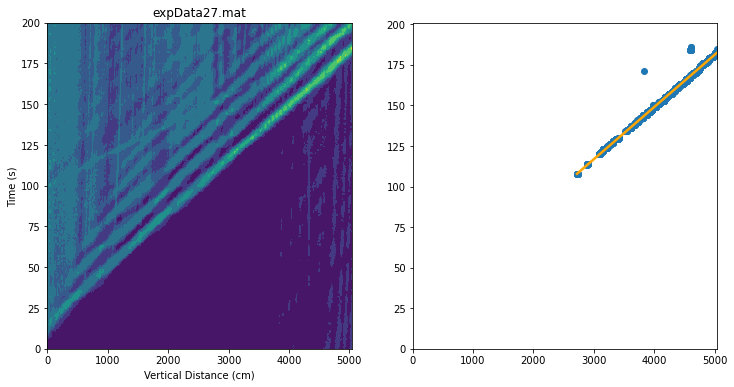

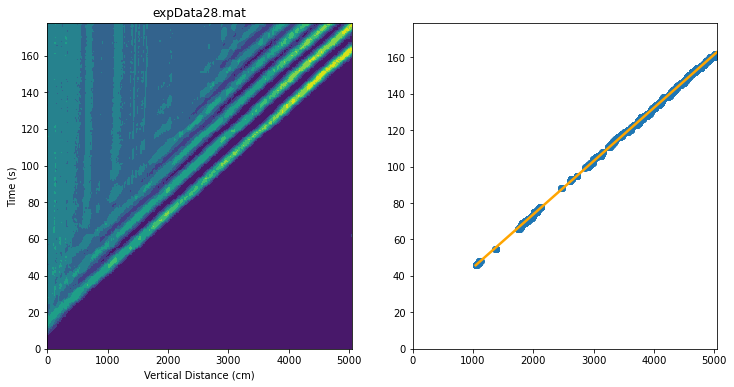

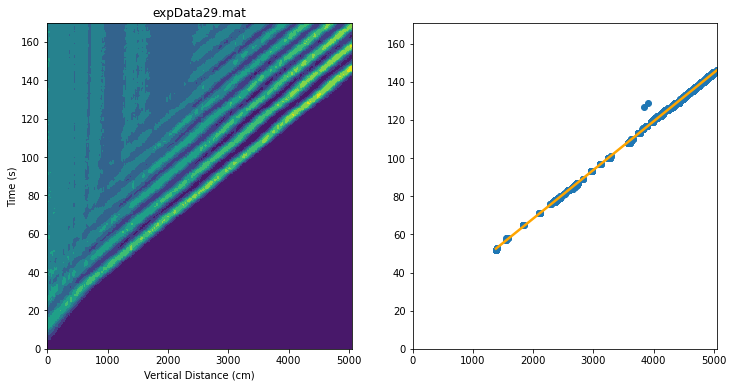

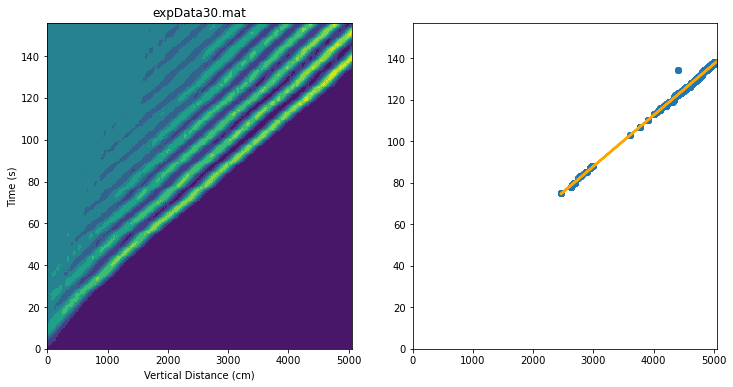

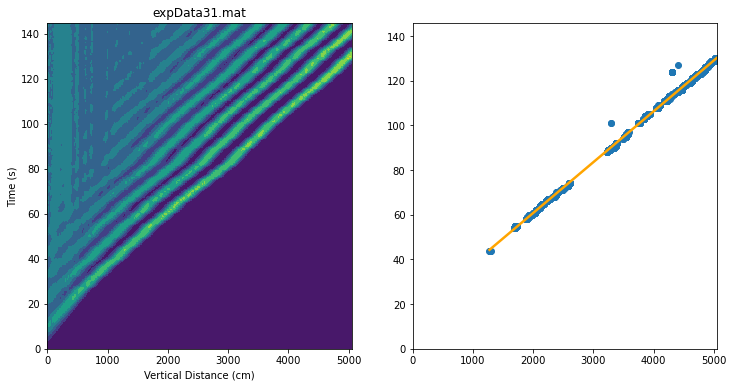

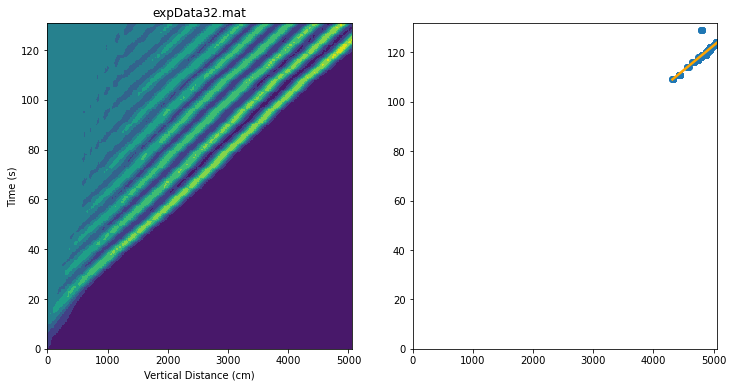

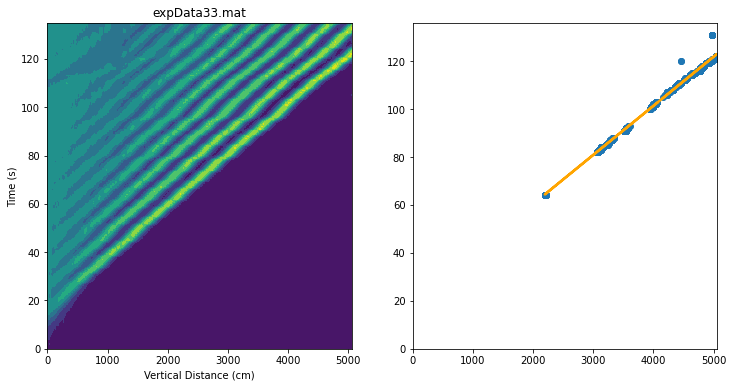

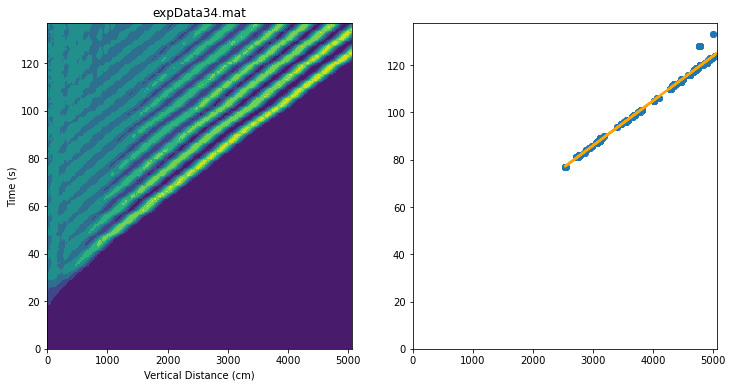

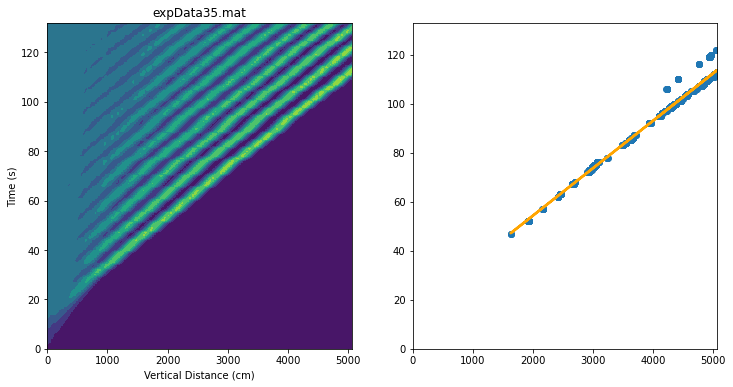

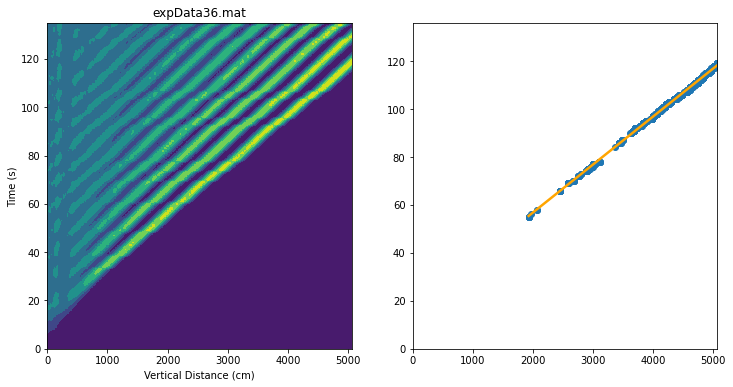

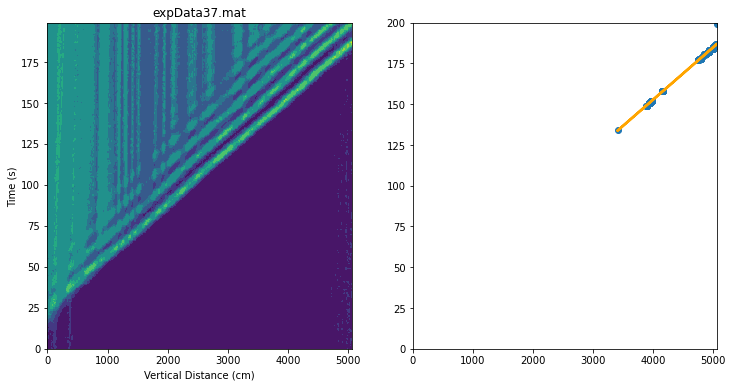

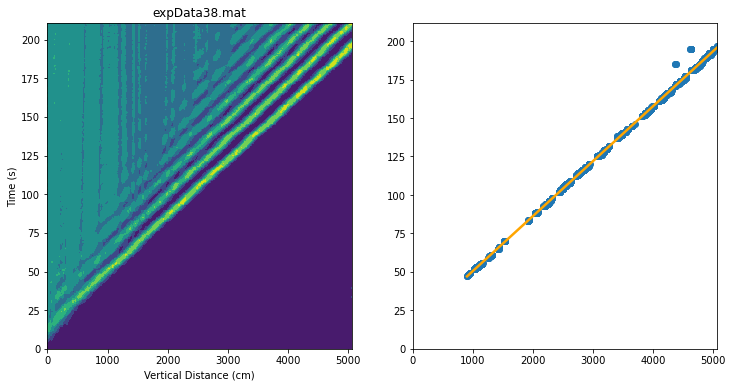

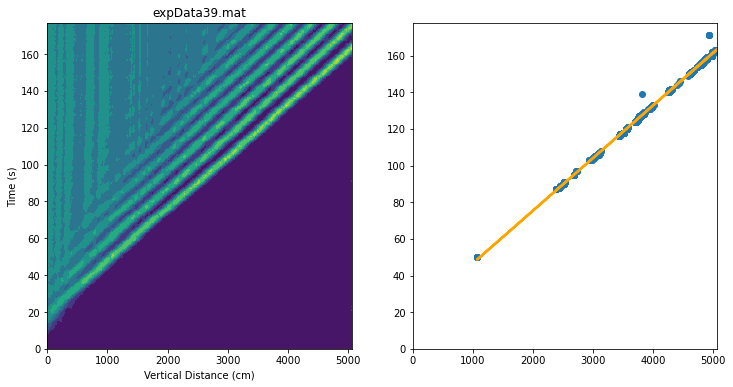

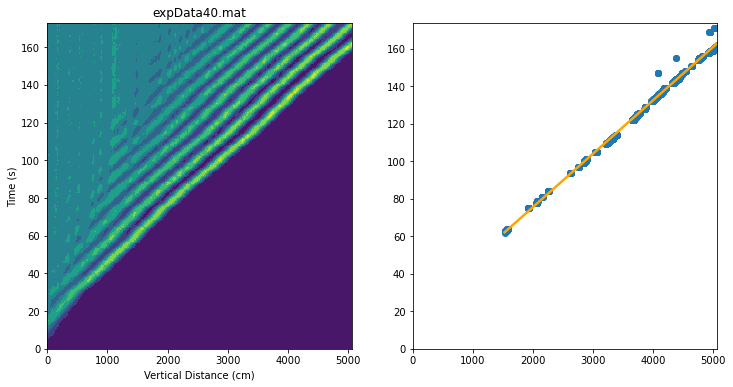

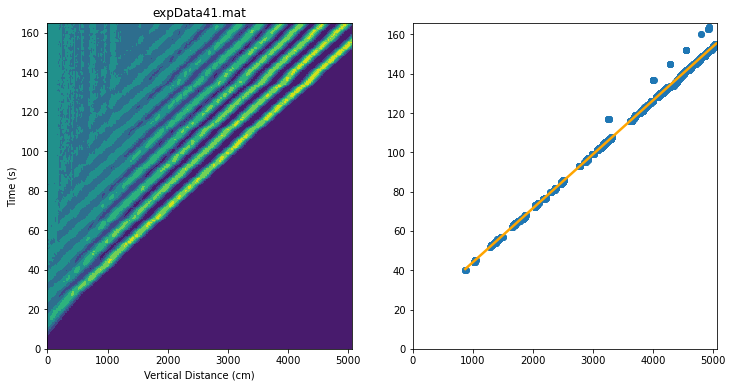

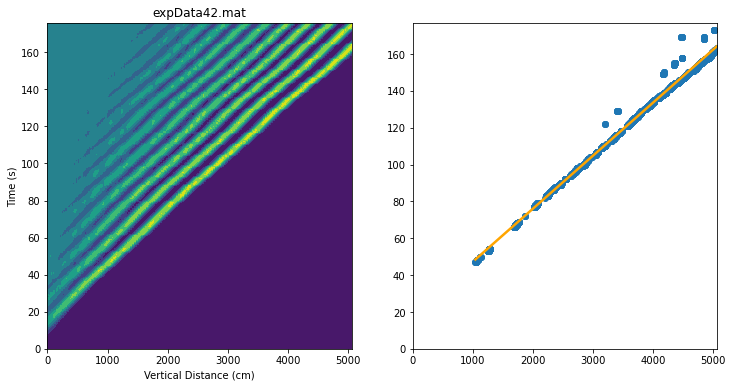

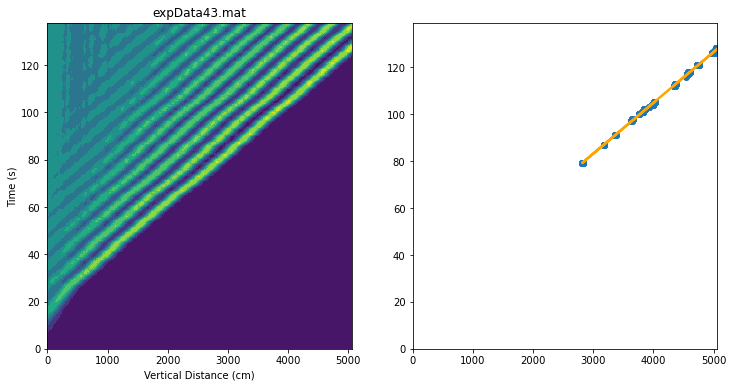

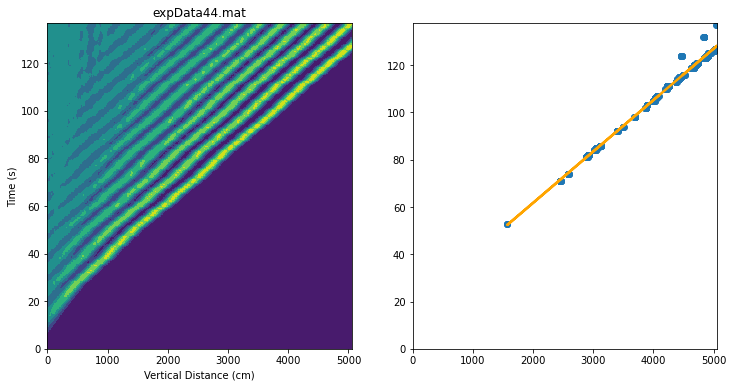

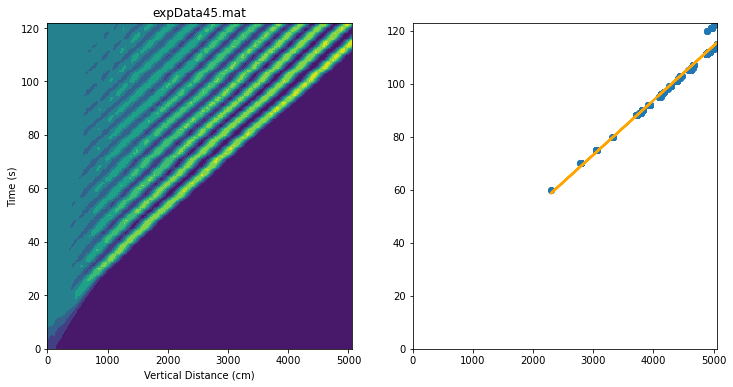

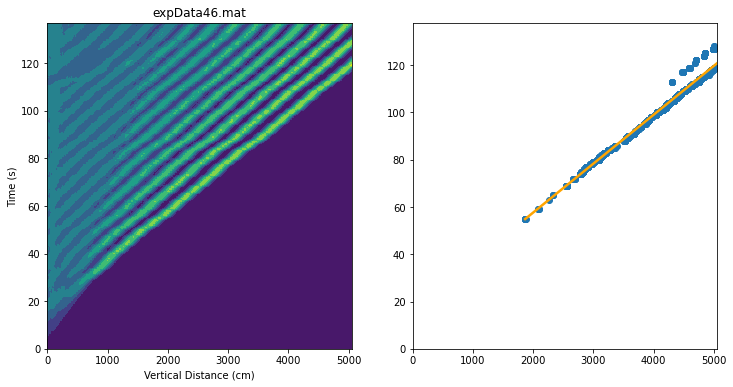

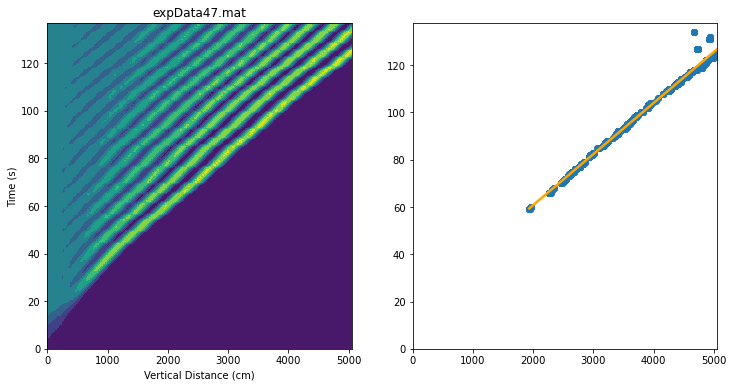

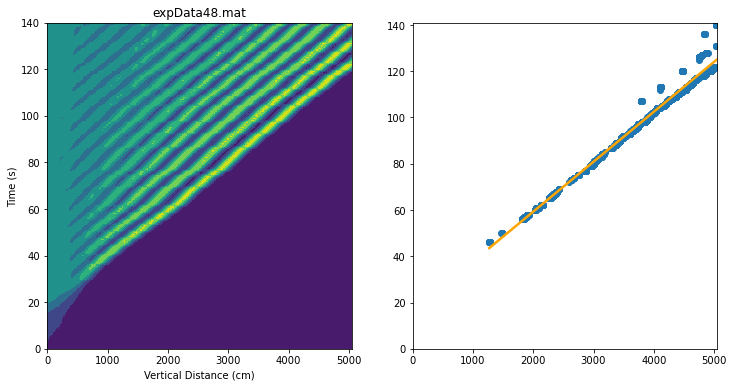

In [15]:
# data sets [17-48]
for num in range(17,49):
    data = 'expData' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    a0 = dictionary['A0'][0,0]
    a0_list.append(a0)
    u0_list.append(dictionary['U0'][0,0])
    
    new_dict = compute_soliton_speed(dictionary)
    
    # append speed to list
    speeds_list.append( (a0, new_dict['real_speed'], num) )
    
    #make two plots side by side
    m = (1 / new_dict['index_speed'])
    y_hat_vals = [m*x + new_dict['b'] for x in new_dict['xvals']]
    
    plt.figure(figsize = (12, 6))
    
    plt.subplot(1, 2, 1)
    plt.contourf(dictionary['Amat'])
    plt.xlabel('Vertical Distance (cm)')
    plt.ylabel('Time (s)')
    plt.title(data)
    
    plt.subplot(1, 2, 2)
    plt.scatter(*zip(*new_dict['solitonIdxs']))
    plt.plot(new_dict['xvals'], y_hat_vals, c = 'orange', linewidth = 2.5)
    plt.xlim(0,dictionary['z_vec'].size)
    plt.ylim(0,dictionary['t_vec'].size)
    
    plt.show()

In [27]:
# speeds_list.sort()
# speeds_list

In [ ]:
# now need to figure out how to compare the experimental speeds to the theoretical speeds
# for each experimental A0, find the value of the theoretical c(A0), and then scale by multiplying this c(A0) to the 
## corresponding U0 value given in each data set

In [19]:
# attempting to find the dimensionalized theoretical speeds for comparison to the experimentally found speeds
theo_speeds_list = []
for a0 in a0_list:
    theo_speed = (a0**2 * np.log(a0**2) - a0**2 + 1) / ((a0-1)**2)
    theo_speeds_list.append(theo_speed)

theo_speeds_arr = np.array(theo_speeds_list)
corresponding_u0_arr = np.array(u0_list)
scaled_theos = theo_speeds_arr * corresponding_u0_arr

In [21]:
scaled_theos_list = scaled_theos.tolist()
for i in range(len(a0_list)):
    scaled_theos_list[i] = (a0_list[i], scaled_theos_list[i])
scaled_theos_list[:10]

[(8.46, 0.5465793224158605),
 (7.36, 0.521662912595589),
 (5.8, 0.48087822507314704),
 (4.16, 0.42803043357842063),
 (10.5, 0.5867008584803399),
 (11.3, 0.6007303919379599),
 (12.3, 0.6171699411044929),
 (1.91, 0.4182163008343644),
 (2.46, 0.45789952216931623),
 (3.05, 0.4946519695804236)]

**checking work**

In [36]:
dict13 = sp.loadmat('expData13.mat')
a0 = dict13['A0']
u0 = dict13['U0']
a0

array([[12.3]])

In [35]:
scaled_theo_speed13 = (a0**2 * np.log(a0**2) - a0**2 + 1) / ((a0-1)**2) * u0
scaled_theo_speed13

array([[0.61716994]])

In [25]:
# theo_speeds_arr

In [26]:
# respective_u0_arr

In [27]:
# scaled_theos

In [52]:
# speeds_list

In [54]:
scaled_theos_list.sort()
# scaled_theos_list
# theo_a0, theo_speed = zip(*scaled_theos_list)

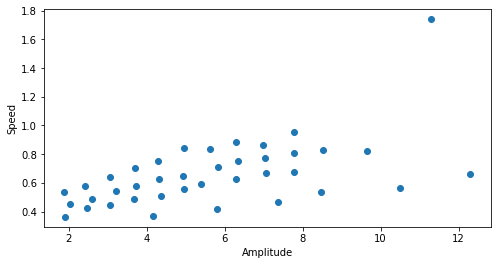

In [50]:
plt.figure(figsize = (8,4))

# experimental speeds
x,y,z = zip(*speeds_list)
plt.scatter(x, y)

# theoretical speeds
# theo_a0, theo_speed = zip(*scaled_theos_list)
# plt.plot(theo_a0, theo_speed)

plt.ylabel('Speed')
plt.xlabel('Amplitude')

plt.show()

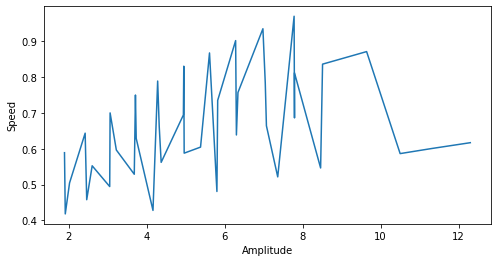

In [51]:
plt.figure(figsize = (8,4))

# theoretical speeds
theo_a0, theo_speed = zip(*scaled_theos_list)
plt.plot(theo_a0, theo_speed)

plt.ylabel('Speed')
plt.xlabel('Amplitude')

plt.show()

**Questions**
* How do we use the U0 from the data to dimensionalize? 
    * *multiply each theoretical speed by the respective U0*

* What does A0 represent in the experiment? Is it the amplitude(area) of the soliton liquid bulge or is it the background, unperturbed liquid condit area?
* What are the other dimensionalization scales used for?
* How to find the ratio of the maximum area to the background area and how is this equal to the soliton amplitude?
    * *since the background amplitude/area is equal to 1, the soliton amplitude, A0, is the area ratio*
* What should I do about negative time values in the time vectors in the data?

### Same thing as above with modified function to try to fix the outliers

In [213]:
speeds_list = []

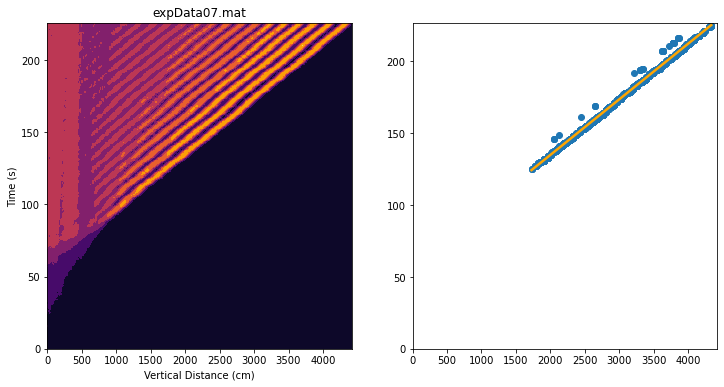

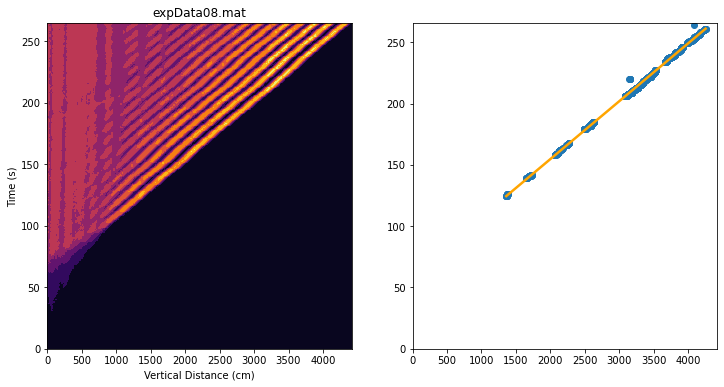

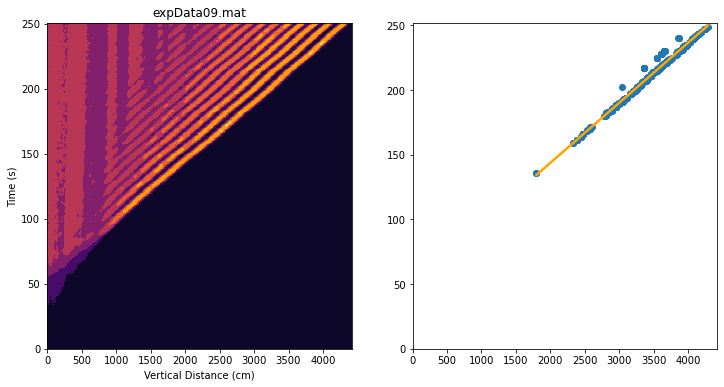

In [214]:
# data sets [7-9]
for num in range(7,10):
    data = 'expData0' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    a0 = dictionary['A0'][0,0]
    
    new_dict = compute_soliton_speed(dictionary)
    m = (1 / new_dict['speed'])
    
    # append speed to list
    speeds_list.append( (a0, new_dict['speed'], num) )
    
    #make two plots side by side
    y_hat_vals = [m*x + new_dict['b'] for x in new_dict['xvals']]
    
    plt.figure(figsize = (12, 6))
    
    plt.subplot(1, 2, 1)
    plt.contourf(dictionary['Amat'])
    plt.xlabel('Vertical Distance (cm)')
    plt.ylabel('Time (s)')
    plt.title(data)
    
    plt.subplot(1, 2, 2)
    plt.scatter(*zip(*new_dict['solitonIdxs']))
    plt.plot(new_dict['xvals'], y_hat_vals, c = 'orange', linewidth = 2.5)
    plt.xlim(0,dictionary['z_vec'].size)
    plt.ylim(0,dictionary['t_vec'].size)
    
    plt.show()    

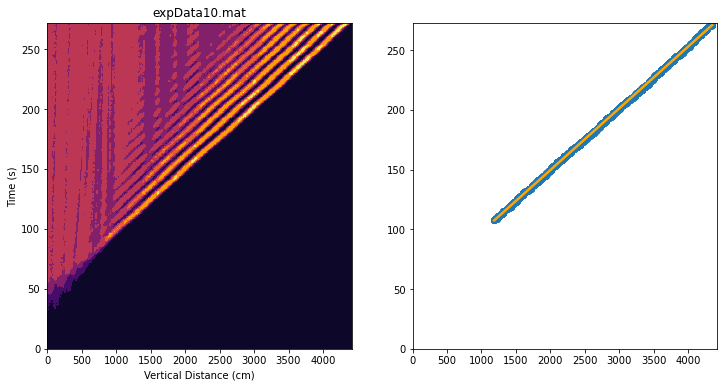

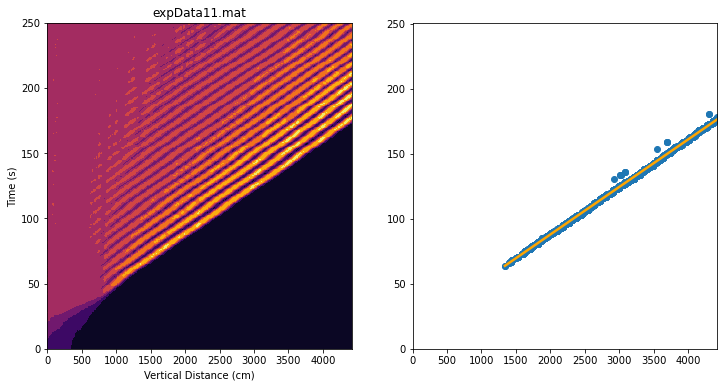

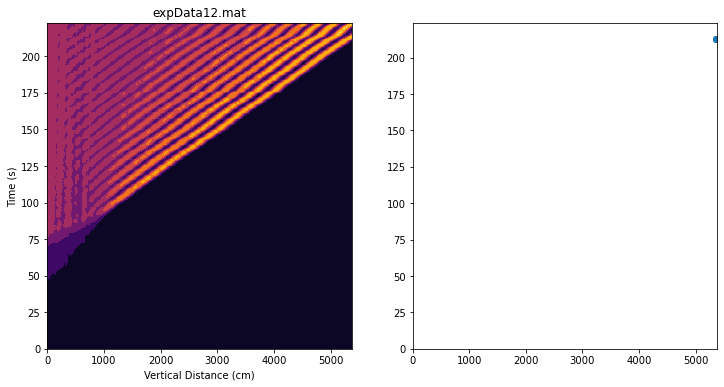

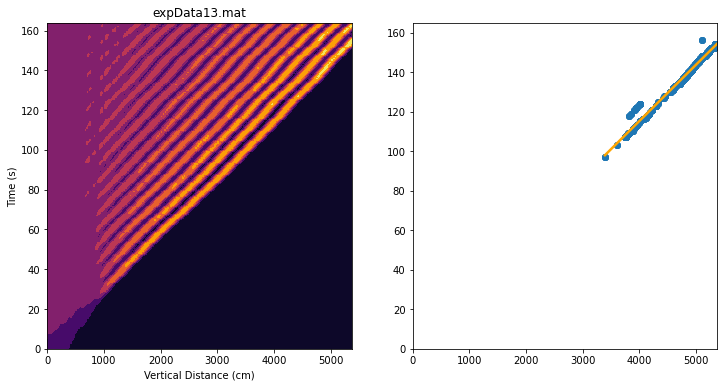

In [215]:
# data sets [10-13]
for num in range(10,14):
    data = 'expData' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    a0 = dictionary['A0'][0,0]
    
    new_dict = compute_soliton_speed(dictionary)
    m = (1 / new_dict['speed'])
    
    # append speed to list
    speeds_list.append( (a0, new_dict['speed'], num) )
    
    #make two plots side by side
    y_hat_vals = [m*x + new_dict['b'] for x in new_dict['xvals']]
    
    plt.figure(figsize = (12, 6))
    
    plt.subplot(1, 2, 1)
    plt.contourf(dictionary['Amat'])
    plt.xlabel('Vertical Distance (cm)')
    plt.ylabel('Time (s)')
    plt.title(data)
    
    plt.subplot(1, 2, 2)
    plt.scatter(*zip(*new_dict['solitonIdxs']))
    plt.plot(new_dict['xvals'], y_hat_vals, c = 'orange', linewidth = 2.5)
    plt.xlim(0,dictionary['z_vec'].size)
    plt.ylim(0,dictionary['t_vec'].size)
    
    plt.show()

In [216]:
speeds_list.sort()
speeds_list

[(4.16, 19.35369135483943, 10),
 (5.8, 21.543080758189912, 9),
 (7.36, 21.192675852146184, 8),
 (8.46, 25.838511189984487, 7),
 (10.5, 27.356601347858586, 11),
 (11.3, 42428967588738.414, 12),
 (12.3, 35.09758468453896, 13)]

In [ ]:
# for dataset12 speed is 107 for original function

**At this point, notice that the modified function is not making enough of a difference in removing outliers from the SolitonIdxs to make a change from the original implementation.**

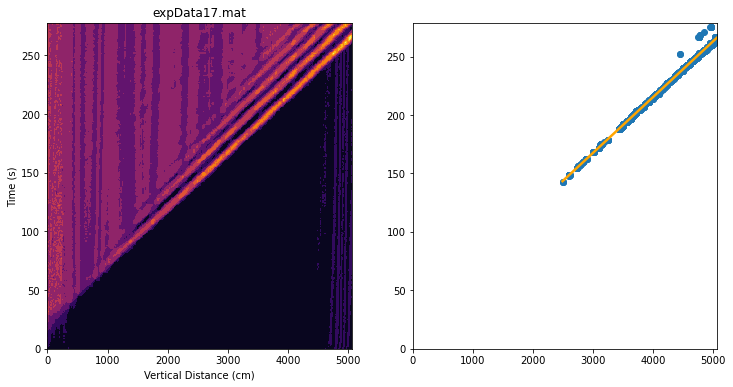

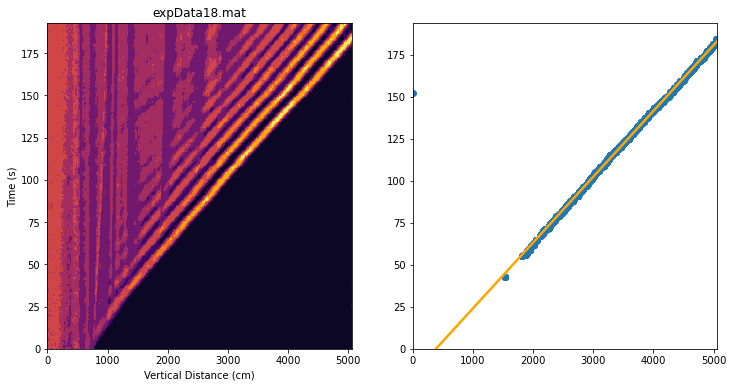

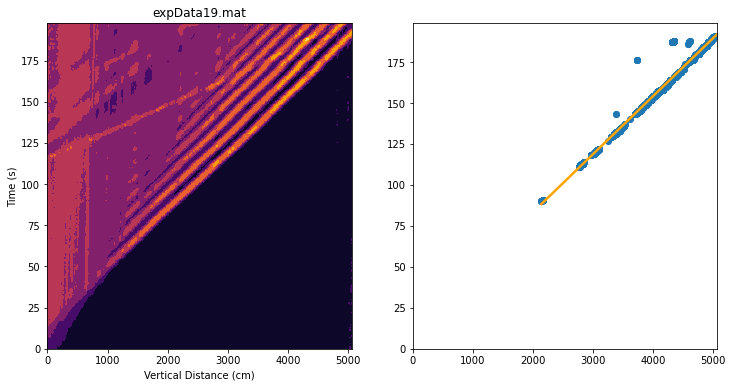

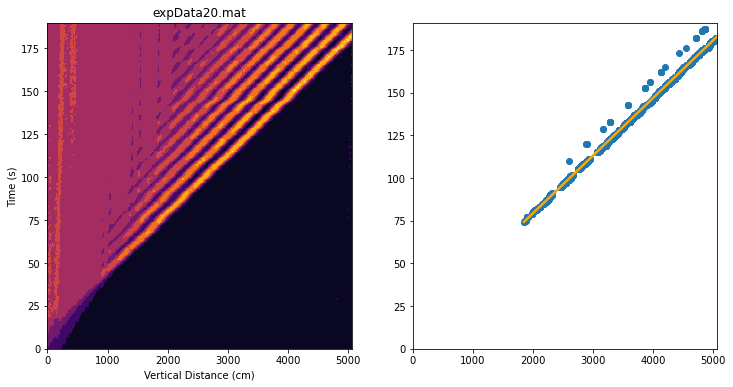

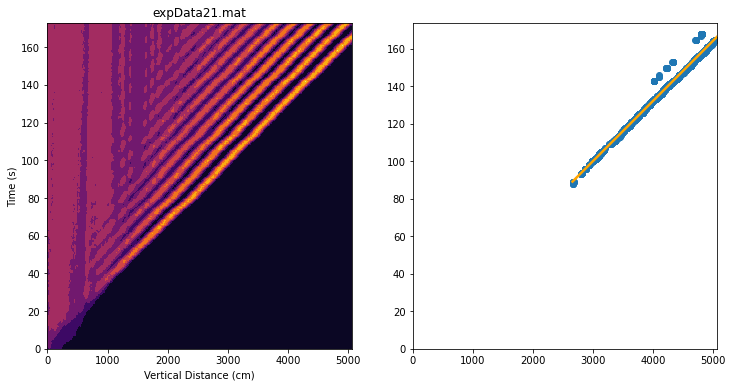

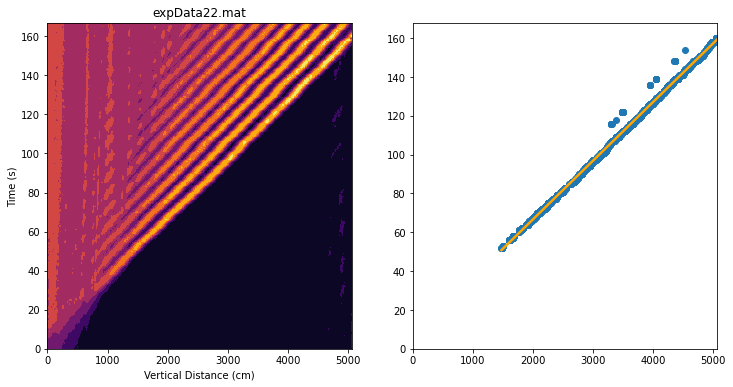

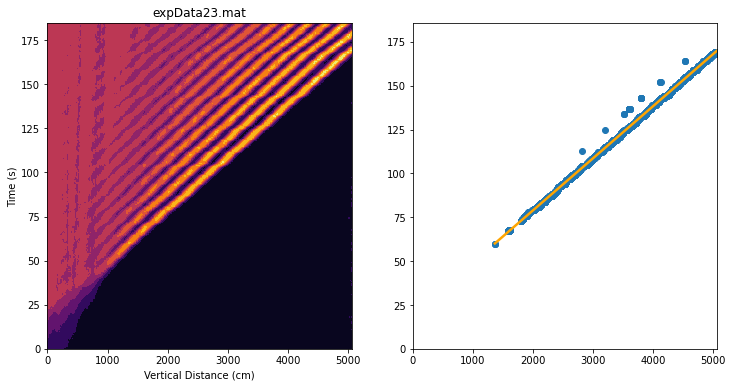

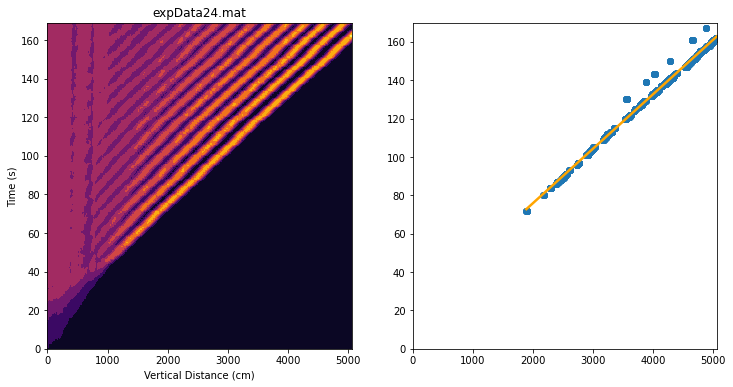

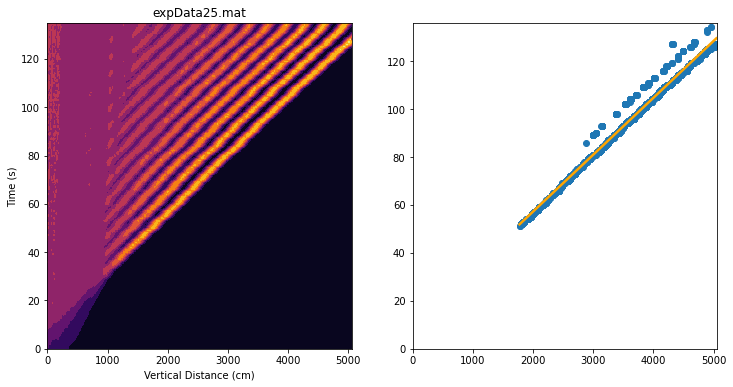

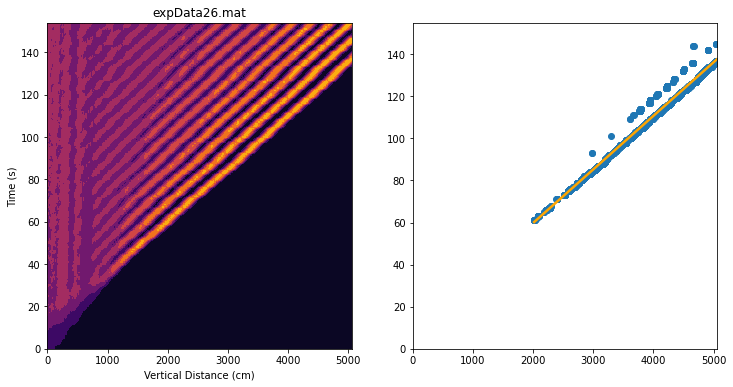

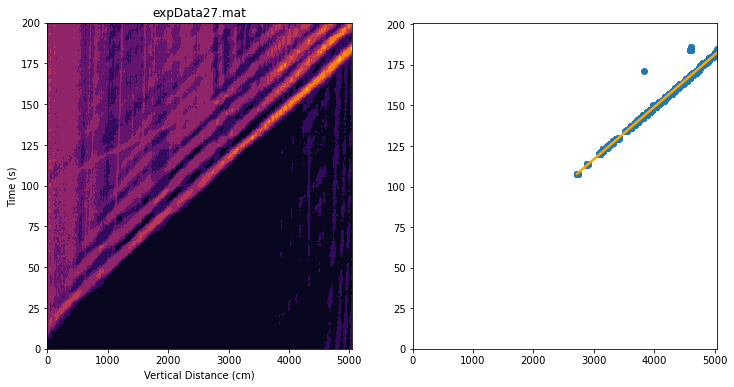

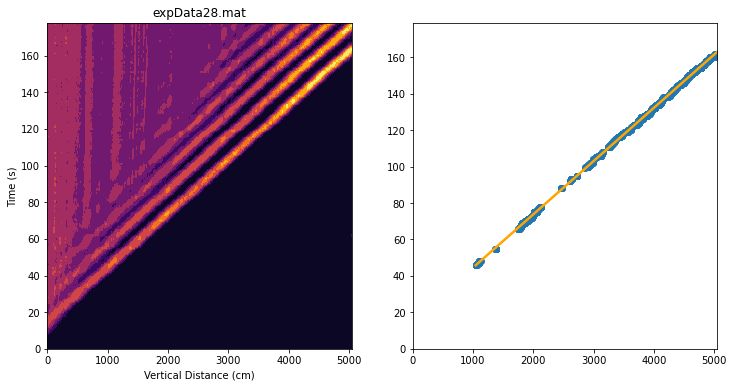

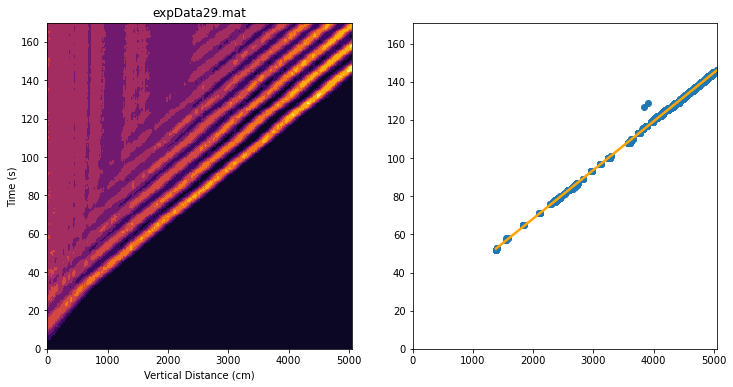

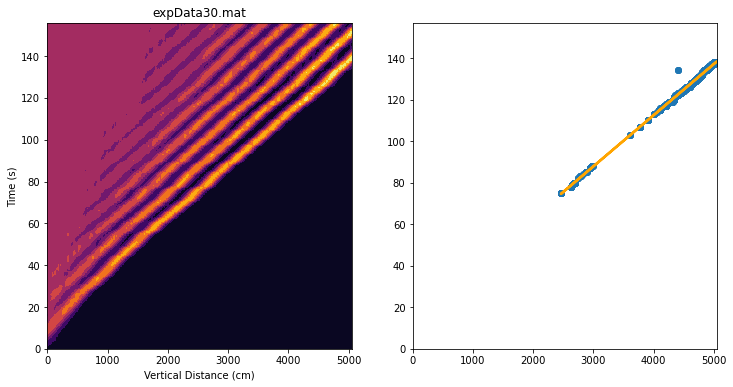

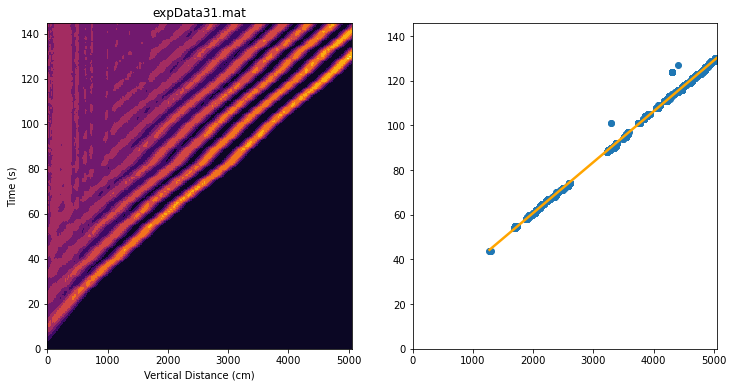

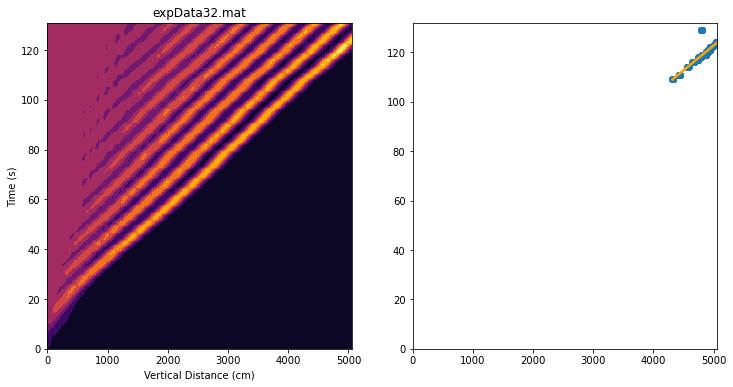

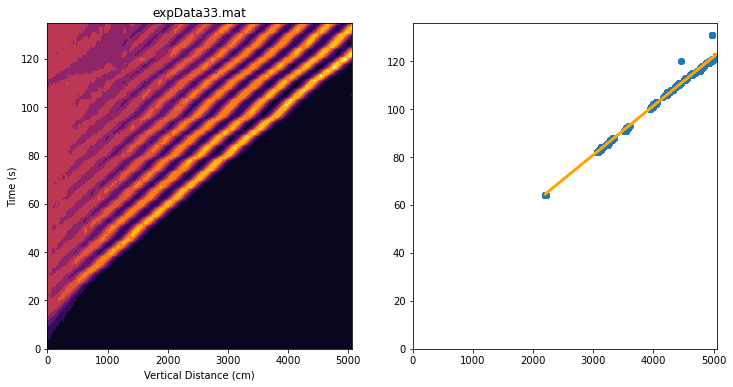

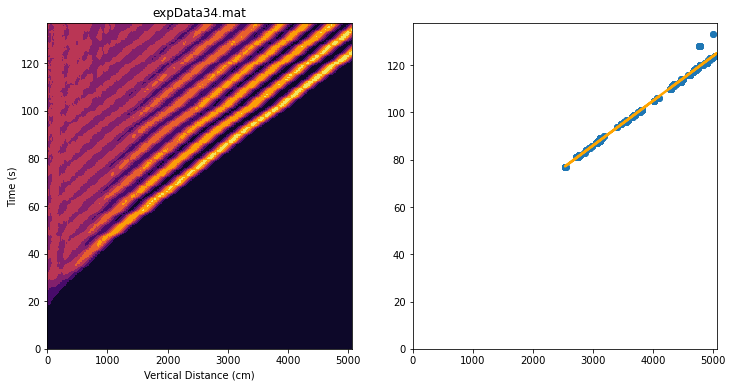

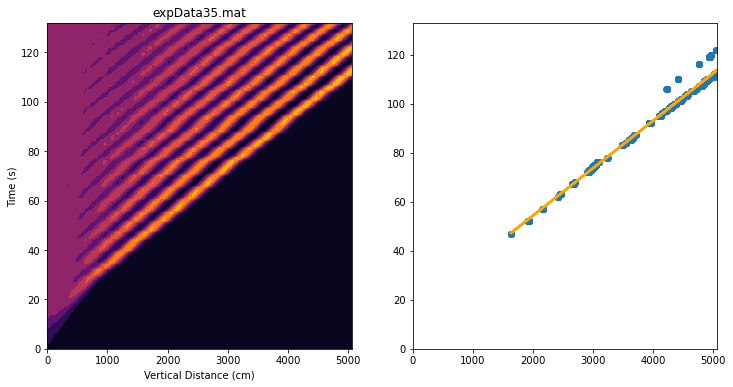

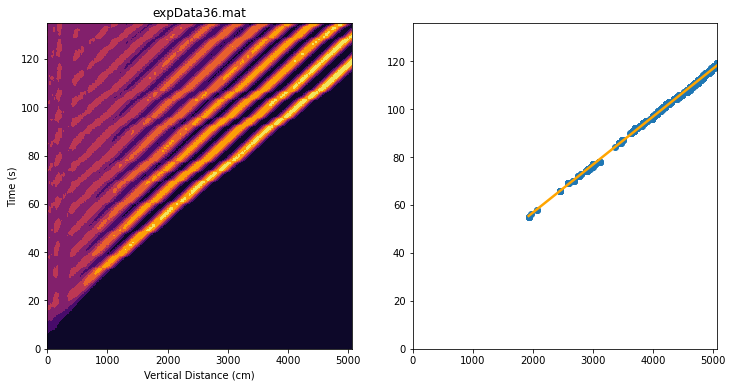

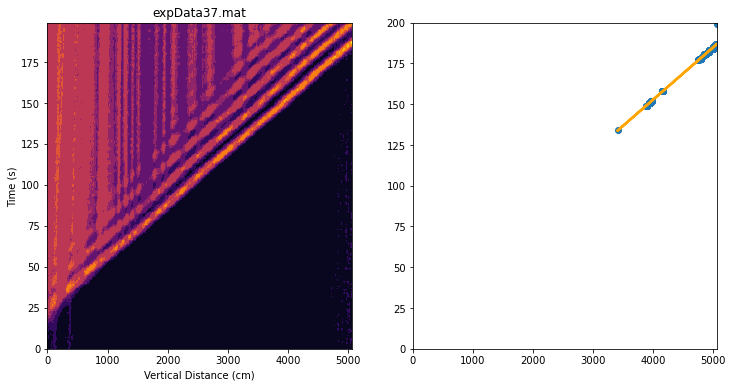

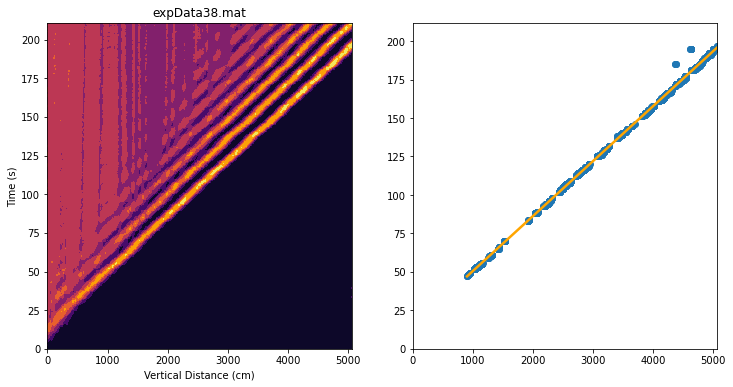

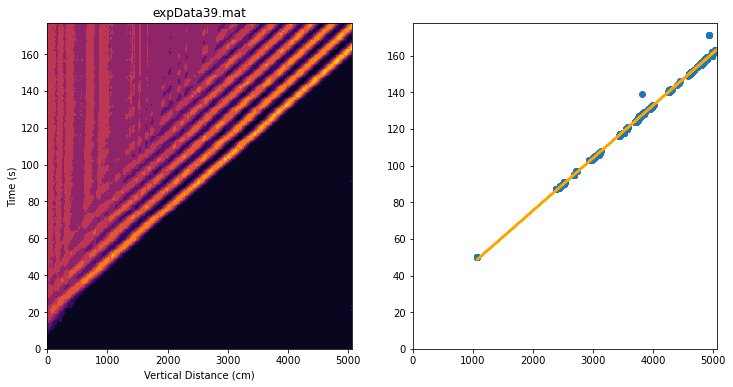

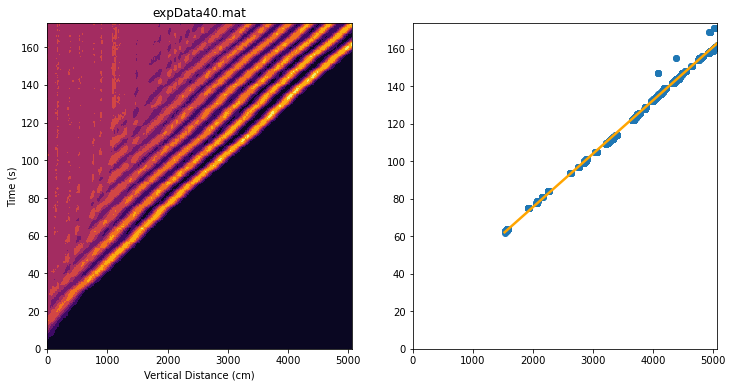

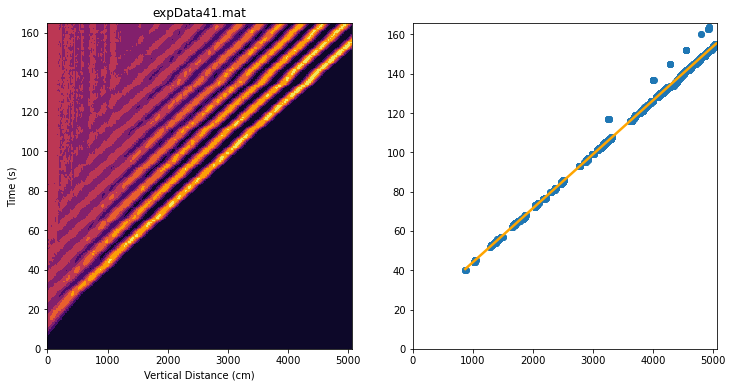

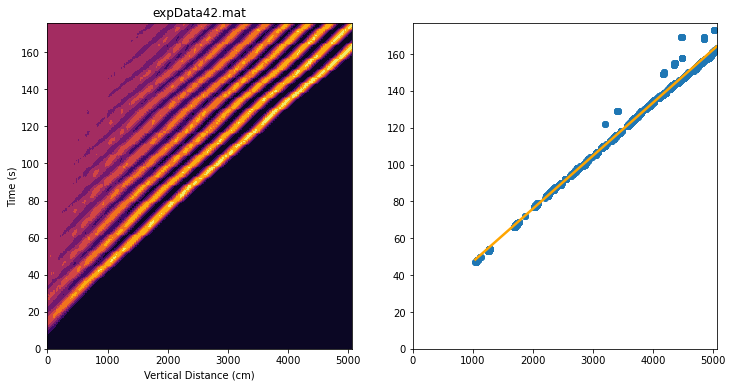

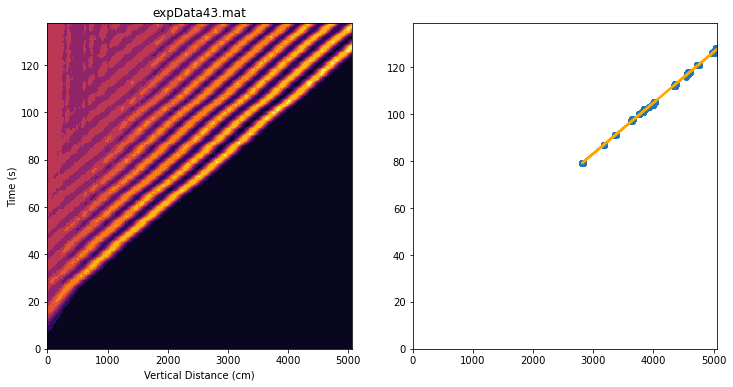

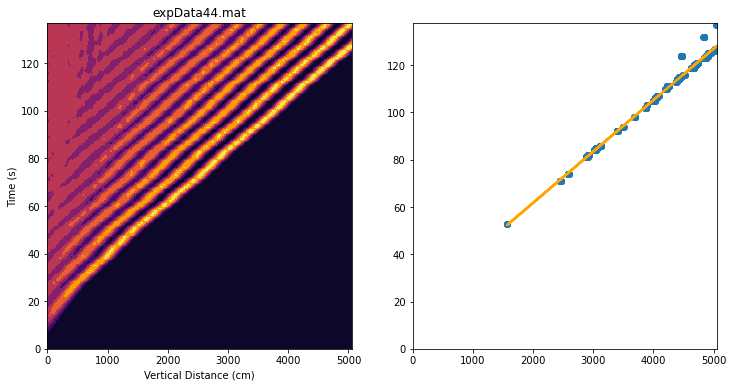

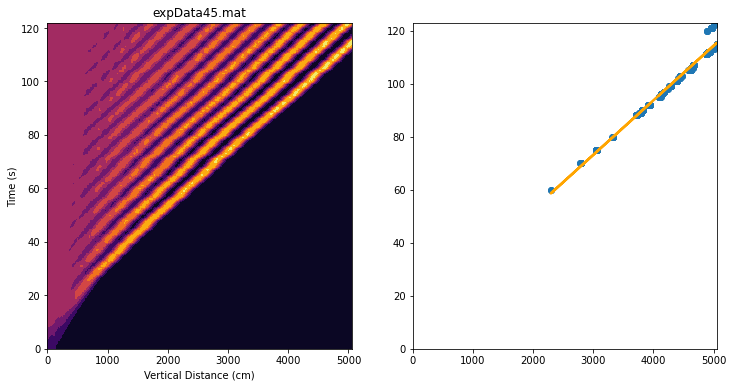

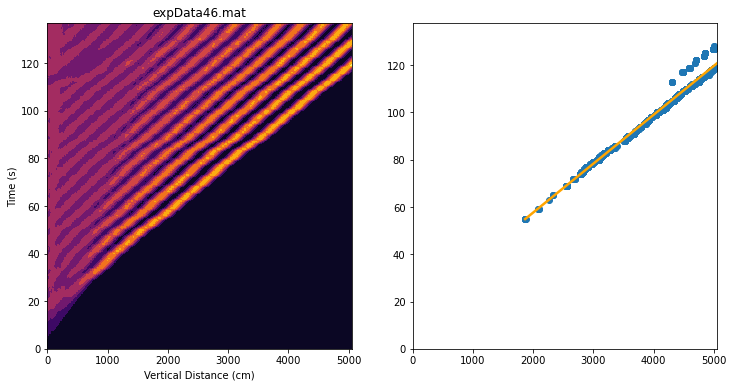

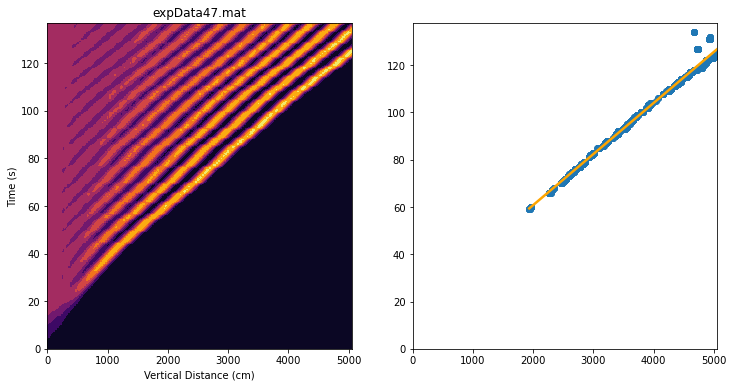

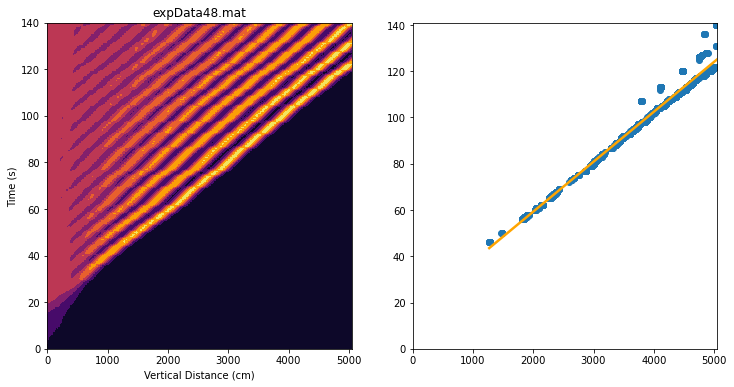

In [206]:
# data sets [17-48]
for num in range(17,49):
    data = 'expData' + str(num) + '.mat'
    dictionary = sp.loadmat(data)
    a0 = dictionary['A0'][0,0]
    
    new_dict = compute_soliton_speed(dictionary)
    m = (1 / new_dict['speed'])
    
    # append speed to list
    speeds_list.append( (a0, new_dict['speed'], num) )
    
    #make two plots side by side
    y_hat_vals = [m*x + new_dict['b'] for x in new_dict['xvals']]
    
    plt.figure(figsize = (12, 6))
    
    plt.subplot(1, 2, 1)
    plt.contourf(dictionary['Amat'])
    plt.xlabel('Vertical Distance (cm)')
    plt.ylabel('Time (s)')
    plt.title(data)
    
    plt.subplot(1, 2, 2)
    plt.scatter(*zip(*new_dict['solitonIdxs']))
    plt.plot(new_dict['xvals'], y_hat_vals, c = 'orange', linewidth = 2.5)
    plt.xlim(0,dictionary['z_vec'].size)
    plt.ylim(0,dictionary['t_vec'].size)
    
    plt.show()

In [68]:
3+4+32

39

In [104]:
# compute_soliton_speed(sp.loadmat('expData45.mat'))

In [186]:
speeds_list.sort()
# len(speeds_list)
# speeds_list[37] = (11.3, 37.24, 12)
# speeds_list

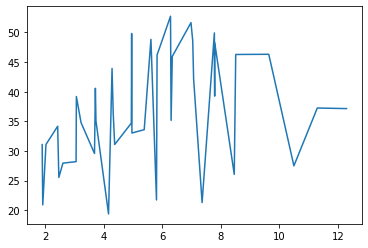

In [184]:
xvals = [s[0] for s in speeds_list]
yvals = [s[1] for s in speeds_list]

plt.plot(xvals, yvals)
plt.show()

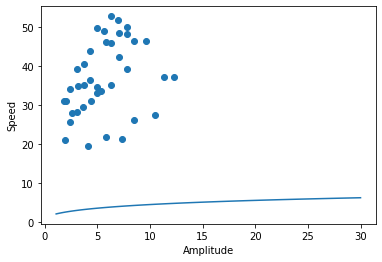

In [187]:
avals = np.linspace(1.1, 30, 100)
cvals = (avals**2 * np.log(avals**2) - avals**2 + 1) / ((avals-1)**2)

x,y,z = zip(*speeds_list)
plt.scatter(x, y)

plt.plot(avals,cvals)
plt.ylabel('Speed')
plt.xlabel('Amplitude')

plt.show()

**Question:** How do you account for error in the speed calculation?

In [ ]:
theoreticals = [a**2 * np.log(a**2) - a**2 + 1) / ((a-1)**2

In [2]:
avals = np.linspace(1.1, 30, 100)
cvals = (avals**2 * np.log(avals**2) - avals**2 + 1) / ((avals-1)**2)

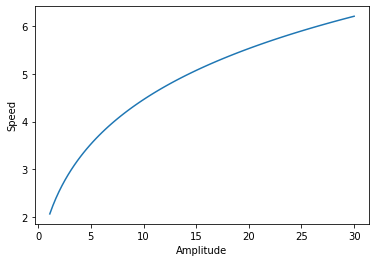

In [3]:
plt.plot(avals,cvals)
plt.ylabel('Speed')
plt.xlabel('Amplitude')
plt.show()

In [41]:
# list(range(17,49))

### More Experiment Trials

In [225]:
dict34 = sp.loadmat('expData34.mat')
# dict34

In [1]:
# dict34['R0']

In [227]:
mat34 = dict34['Amat']

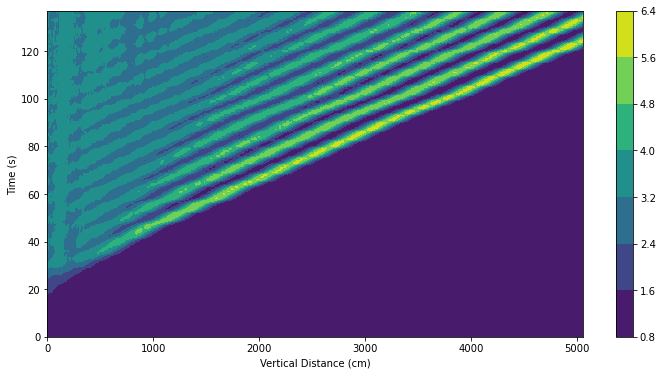

In [228]:
plt.figure(figsize = (12,6))
plt.contourf(mat34)
plt.set_cmap('viridis')
plt.colorbar()
plt.xlabel('Vertical Distance (cm)')
plt.ylabel('Time (s)')
plt.show()

In [118]:
dict17 = sp.loadmat('expData17.mat')
# dict17

In [119]:
mat17 = dict17['Amat']
dict17['A0']

array([[1.91]])

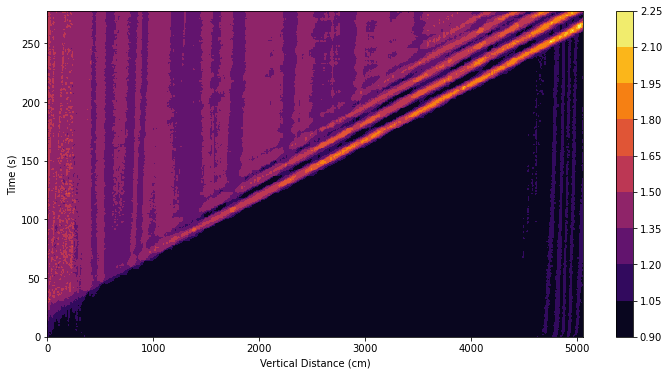

In [30]:
plt.figure(figsize = (12,6))
plt.contourf(mat17)
plt.set_cmap('inferno')
plt.colorbar()
plt.xlabel('Vertical Distance (cm)')
plt.ylabel('Time (s)')
plt.show()

In [62]:
dict19 = sp.loadmat('expData19.mat')
# dict19

In [63]:
mat19 = dict19['Amat']

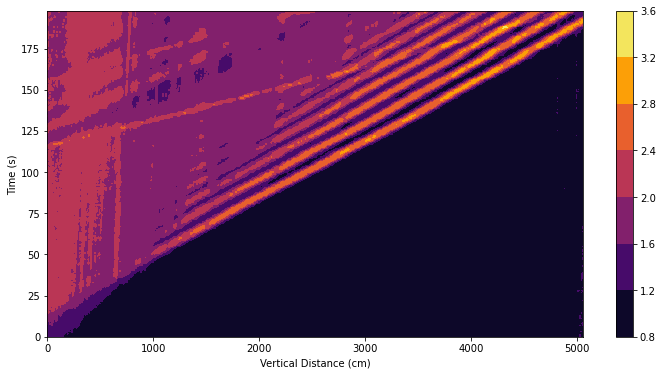

In [64]:
plt.figure(figsize = (12,6))
plt.contourf(mat19)
# plt.set_cmap('inferno')
plt.colorbar()
plt.xlabel('Vertical Distance (cm)')
plt.ylabel('Time (s)')
plt.show()

# Scratch

In [18]:
wave.size

8680

In [19]:
mat08 = sp.loadmat('expData08.mat')
print(mat08['A0'], mat08['A0_error'])

[[7.36]] [[0.7]]


In [20]:
arr = np.array([2,3,3,4,5,6,8])

In [21]:
lst = [(0,0), (1,3), (2,6), (3,9), (4,12), (5,15)]
yvals = [e[1] for e in lst]

In [31]:
# plt.plot(yvals, 'o')
# plt.axis('equal')
# xvals = np.arange(6)
# plt.show()

In [49]:
full_maxj = 0                   # find the maximum j coordinate within the indices
for idx in fullWaveIdxs:
    if idx[1] > full_maxj:
        full_maxj = idx[1]
full_maxj

4353

In [50]:
full_maxjIdxs = []                # find indices with this maxj coordinate
for idx in fullWaveIdxs:
    if idx[1] == full_maxj:
        full_maxjIdxs.append(idx)
full_maxjIdxs

[(226, 4353)]

In [51]:
full_mini = full_maxj               # find the minimum i coordinate within the maxj indices
for idx in full_maxjIdxs:      
    if idx[0] < full_mini:
        full_mini = idx[0]
# full_mini

In [52]:
solitonIdx2 = (0,0)                   # the index from the maxj index list with the mini coordinate is the soliton
for idx in full_maxjIdxs:
    if idx[0] == full_mini:
        solitonIdx2 = idx
solitonIdx2

(226, 4353)

**Half Wave**

In [81]:
halfWaveIdxs = []                  # first get possible indexes
for i in range(227):
    for j in range(2218):
        if (mat07[i,j]>8.26) & (mat07[i,j]<8.66):
            halfWaveIdxs.append((i,j))
#int(np.floor(4418*.75))

In [82]:
half_maxj = 0                  # find the maximum j coordinate within the indices
for idx in halfWaveIdxs:
    if idx[1] > half_maxj:
        half_maxj = idx[1]
half_maxj

2217

In [83]:
half_maxjIdxs = []                # find indices with this maxj coordinate
for idx in halfWaveIdxs:
    if idx[1] == half_maxj:
        half_maxjIdxs.append(idx)        
half_maxjIdxs

[(143, 2217), (144, 2217), (153, 2217)]

In [84]:
half_mini = half_maxj               # find the minimum i coordinate within the maxj indices
for idx in half_maxjIdxs:      
    if idx[0] < half_mini:
        half_mini = idx[0]
# half_mini

In [85]:
solitonIdx1 = (0,0)                   # the index from the maxj index list with the mini coordinate is the soliton
for idx in half_maxjIdxs:
    if idx[0] == half_mini:
        solitonIdx1 = idx
solitonIdx1

(143, 2217)

(0.0, 227.0)

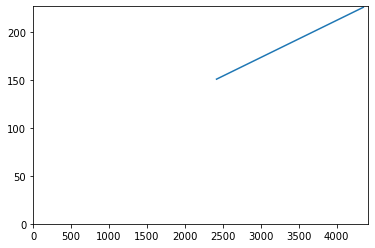

In [86]:
plt.plot([2417,4353], [151,226])
plt.xlim(0,4417)
plt.ylim(0,227)

In [77]:
# slope07 = (226-151)/(4353-2417)
# slope07 = 

In [87]:
speed07 = (solitonIdx2[1] - solitonIdx1[1]) / (solitonIdx2[0] - solitonIdx1[0])
speed07

25.734939759036145

**Function**

In [41]:
dictionary = sp.loadmat('expData07.mat')

mat = dictionary['Amat']
times = mat.shape[0]
distances = mat.shape[1]
a0 = dictionary['A0'][0,0]
a0_error = dictionary['A0_error'][0,0]
solitonAmpRange = ((a0 - a0_error), (a0 + a0_error))

## FULL WAVE
fullWaveIdxs = []                    # first get possible soliton indexes
for i in range(times):
    for j in range(distances):
        if (mat[i,j]>solitonAmpRange[0]) & (mat[i,j]<solitonAmpRange[1]):
            fullWaveIdxs.append((i,j))

full_maxj = 0                   # find the maximum j coordinate within the indices
for idx in fullWaveIdxs:
    if idx[1] > full_maxj:
        full_maxj = idx[1]

full_maxjIdxs = []                # find indices with this maxj coordinate
for idx in fullWaveIdxs:
    if idx[1] == full_maxj:
        full_maxjIdxs.append(idx)

full_mini = full_maxj               # find the minimum i coordinate within the maxj indices
for idx in full_maxjIdxs:      
    if idx[0] < full_mini:
        full_mini = idx[0]

solitonIdx2 = (0,0)                 # the index from the maxj index list with the mini coordinate is the soliton
for idx in full_maxjIdxs:
    if idx[0] == full_mini:
        solitonIdx2 = idx


## 3/4 WAVE
halfWaveIdxs = []                  # first get possible soliton indexes from 75% of the data
for i in range(times):
    for j in range(int(np.floor(distances*.75))):
        if (mat[i,j]>solitonAmpRange[0]) & (mat[i,j]<solitonAmpRange[1]):
            halfWaveIdxs.append((i,j))

half_maxj = 0                     # find the maximum j coordinate within the indices
for idx in halfWaveIdxs:
    if idx[1] > half_maxj:
        half_maxj = idx[1]

half_maxjIdxs = []                # find indices with this maxj coordinate
for idx in halfWaveIdxs:
    if idx[1] == half_maxj:
        half_maxjIdxs.append(idx)        

half_mini = half_maxj               # find the minimum i coordinate within the maxj indices
for idx in half_maxjIdxs:      
    if idx[0] < half_mini:
        half_mini = idx[0]

solitonIdx1 = (0,0)                  # the index from the maxj index list with the mini coordinate is the soliton
for idx in half_maxjIdxs:
    if idx[0] == half_mini:
        solitonIdx1 = idx

## Find speed of soliton
speed = (solitonIdx2[1] - solitonIdx1[1]) / (solitonIdx2[0] - solitonIdx1[0])

In [46]:
solitonIdx2

(226, 4353)

In [29]:
def get_soliton_speed(dictionary):
    mat = dictionary['Amat']
    times = mat.shape[0]
    distances = mat.shape[1]
    a0 = dictionary['A0'][0,0]
    a0_error = dictionary['A0_error'][0,0]
    solitonAmpRange = ((a0 - a0_error), (a0 + a0_error))
    
    ## FULL WAVE
    fullWaveIdxs = []                    # first get possible soliton indexes
    for i in range(times):
        for j in range(distances):
            if (mat[i,j]>solitonAmpRange[0]) & (mat[i,j]<solitonAmpRange[1]):
                fullWaveIdxs.append((i,j))

    full_maxj = 0                   # find the maximum j coordinate within the indices
    for idx in fullWaveIdxs:
        if idx[1] > full_maxj:
            full_maxj = idx[1]
            
    full_maxjIdxs = []                # find indices with this maxj coordinate
    for idx in fullWaveIdxs:
        if idx[1] == full_maxj:
            full_maxjIdxs.append(idx)

    full_mini = full_maxj               # find the minimum i coordinate within the maxj indices
    for idx in full_maxjIdxs:      
        if idx[0] < full_mini:
            full_mini = idx[0]

    solitonIdx2 = (0,0)                 # the index from the maxj index list with the mini coordinate is the soliton
    for idx in full_maxjIdxs:
        if idx[0] == full_mini:
            solitonIdx2 = idx

            
    ## 3/4 WAVE
    halfWaveIdxs = []                  # first get possible soliton indexes from 75% of the data
    for i in range(times):
        for j in range(int(np.floor(distances*.75))):
            if (mat[i,j]>solitonAmpRange[0]) & (mat[i,j]<solitonAmpRange[1]):
                halfWaveIdxs.append((i,j))

    half_maxj = 0                     # find the maximum j coordinate within the indices
    for idx in halfWaveIdxs:
        if idx[1] > half_maxj:
            half_maxj = idx[1]

    half_maxjIdxs = []                # find indices with this maxj coordinate
    for idx in halfWaveIdxs:
        if idx[1] == half_maxj:
            half_maxjIdxs.append(idx)        

    half_mini = half_maxj               # find the minimum i coordinate within the maxj indices
    for idx in half_maxjIdxs:      
        if idx[0] < half_mini:
            half_mini = idx[0]
            
    solitonIdx1 = (0,0)                  # the index from the maxj index list with the mini coordinate is the soliton
    for idx in half_maxjIdxs:
        if idx[0] == half_mini:
            solitonIdx1 = idx
            
    ## Find speed of soliton
    speed = (solitonIdx2[1] - solitonIdx1[1]) / (solitonIdx2[0] - solitonIdx1[0])
    
    return speed

In [30]:
get_soliton_speed(sp.loadmat('expData07.mat'))

26.025

In [26]:
np.floor(4418*.75)

3313.0

In [32]:
# plt.plot(waveIdxs, 'o')
# plt.axis('equal')
# plt.show()

### Dataframe method?
* find two points on the leading edge and calculate the slope of the line (linear)

In [99]:
# df07 = pd.DataFrame(mat07)
# df07

In [98]:
# top = df07.head(50)[(df07.head(50) >= A0 - A0_error) & (df07.head(50) <= A0 + A0_error)]

In [96]:
# plt.figure(figsize = (12,6))
# plt.contourf(df07)
# plt.colorbar()
# plt.xlabel('Vertical Distance (cm)')
# plt.ylabel('Time (s)')
# plt.show()

In [95]:
# arr = np.arange(1, 19).reshape(3, 6)
# df = pd.DataFrame(arr)
# df

In [94]:
# new = df[(df>4) & (df<12)]
# new

In [92]:
# new[new.notnull()].max()